In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import mlflow
import mlflow.sklearn

from sklearn.feature_extraction import DictVectorizer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

from mlflow.tracking import MlflowClient

In [2]:
df = pd.read_csv('../data/ship_fuel_efficiency.csv')
df.head()

,ship_id,ship_type,route_id,month,distance,fuel_type,fuel_consumption,CO2_emissions,weather_conditions,engine_efficiency
0,NG001,Oil Service Boat,Warri-Bonny,January,132.26,HFO,3779.77,10625.76,Stormy,92.14
1,NG001,Oil Service Boat,Port Harcourt-Lagos,February,128.52,HFO,4461.44,12779.73,Moderate,92.98
2,NG001,Oil Service Boat,Port Harcourt-Lagos,March,67.30,HFO,1867.73,5353.01,Calm,87.61
3,NG001,Oil Service Boat,Port Harcourt-Lagos,April,71.68,Diesel,2393.51,6506.52,Stormy,87.42
4,NG001,Oil Service Boat,Lagos-Apapa,May,134.32,HFO,4267.19,11617.03,Calm,85.61


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ship_id             1440 non-null   object 
 1   ship_type           1440 non-null   object 
 2   route_id            1440 non-null   object 
 3   month               1440 non-null   object 
 4   distance            1440 non-null   float64
 5   fuel_type           1440 non-null   object 
 6   fuel_consumption    1440 non-null   float64
 7   CO2_emissions       1440 non-null   float64
 8   weather_conditions  1440 non-null   object 
 9   engine_efficiency   1440 non-null   float64
dtypes: float64(4), object(6)
memory usage: 112.6+ KB


In [4]:
df.isnull().sum()

ship_id               0
ship_type             0
route_id              0
month                 0
distance              0
fuel_type             0
fuel_consumption      0
CO2_emissions         0
weather_conditions    0
engine_efficiency     0
dtype: int64

In [5]:
df.duplicated().sum()

0

## EDA & Feature Engineering

### EDA - Categorical vs Categorical

In [6]:
def unique_counts_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Count unique values in each categorical column of a DataFrame
    """

    unique_info = []
    for col in df.select_dtypes(['object']).columns:
        unique_count = df[col].nunique()
        unique_values = df[col].unique()
        unique_info.append({
            'column': col,
            'unique_count': unique_count,
            'unique_values': unique_values
        })
     
    return pd.DataFrame(unique_info)

In [7]:
unique_df = unique_counts_values(df)
unique_df.head()

,column,unique_count,unique_values
0,ship_id,120,"[NG001, NG002, NG003, NG004, NG005, NG006, NG0..."
1,ship_type,4,"[Oil Service Boat, Fishing Trawler, Surfer Boa..."
2,route_id,4,"[Warri-Bonny, Port Harcourt-Lagos, Lagos-Apapa..."
3,month,12,"[January, February, March, April, May, June, J..."
4,fuel_type,2,"[HFO, Diesel]"


In [8]:
unique_df

,column,unique_count,unique_values
0,ship_id,120,"[NG001, NG002, NG003, NG004, NG005, NG006, NG0..."
1,ship_type,4,"[Oil Service Boat, Fishing Trawler, Surfer Boa..."
2,route_id,4,"[Warri-Bonny, Port Harcourt-Lagos, Lagos-Apapa..."
3,month,12,"[January, February, March, April, May, June, J..."
4,fuel_type,2,"[HFO, Diesel]"
5,weather_conditions,3,"[Stormy, Moderate, Calm]"


now lets do plotting

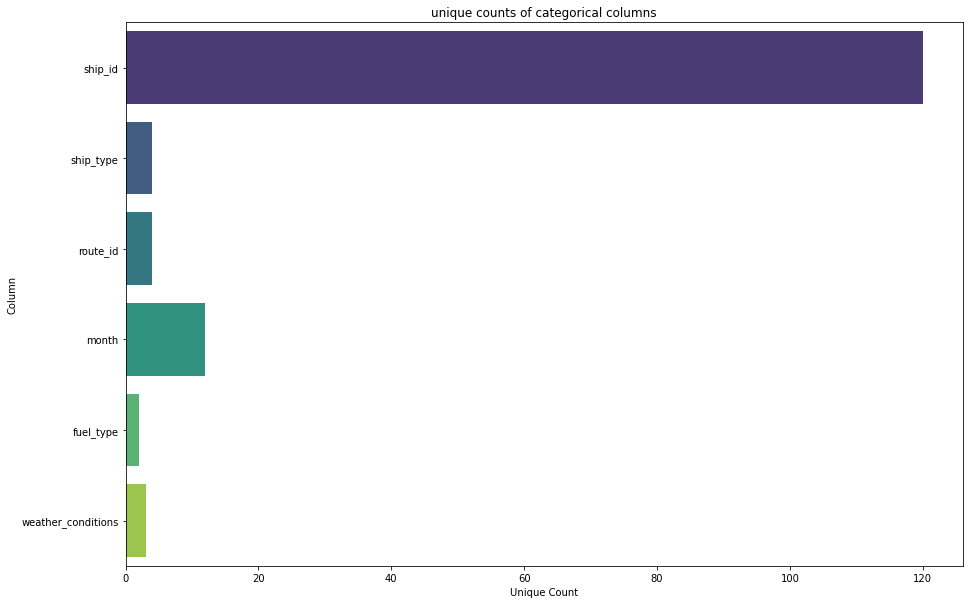

In [10]:
def plot_unique_counts(unique_df: pd.DataFrame) -> None:
    """
    Plot unique counts of categorical columns in a DataFrame
    """

    plt.figure(figsize=(15, 10))
    sns.barplot(x='unique_count', y='column', data=unique_df, palette='viridis')
    plt.title('unique counts of categorical columns')
    plt.xlabel('Unique Count')
    plt.ylabel('Column')
    plt.show()

plot_unique_counts(unique_df)


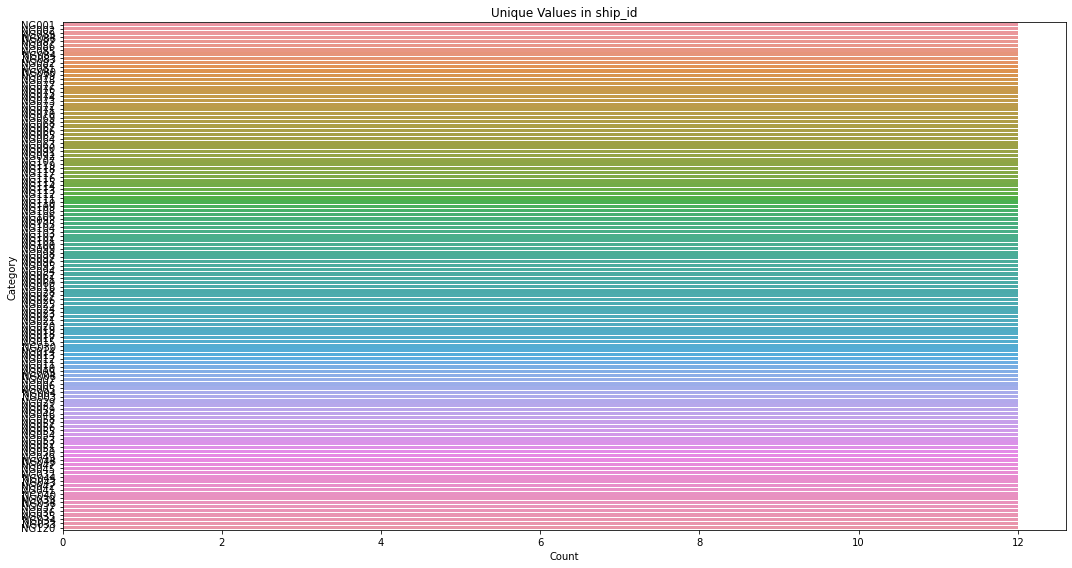

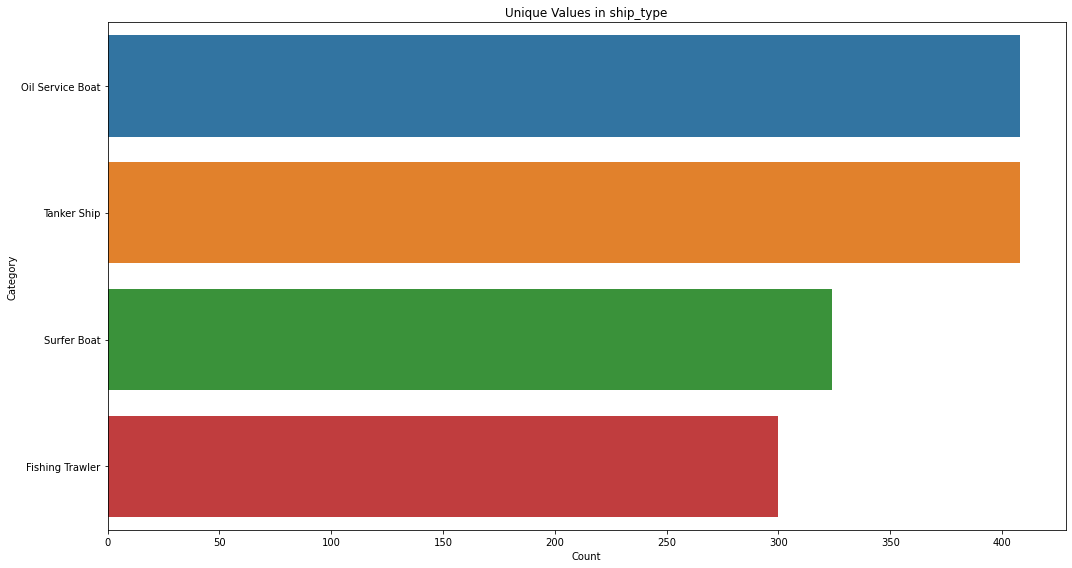

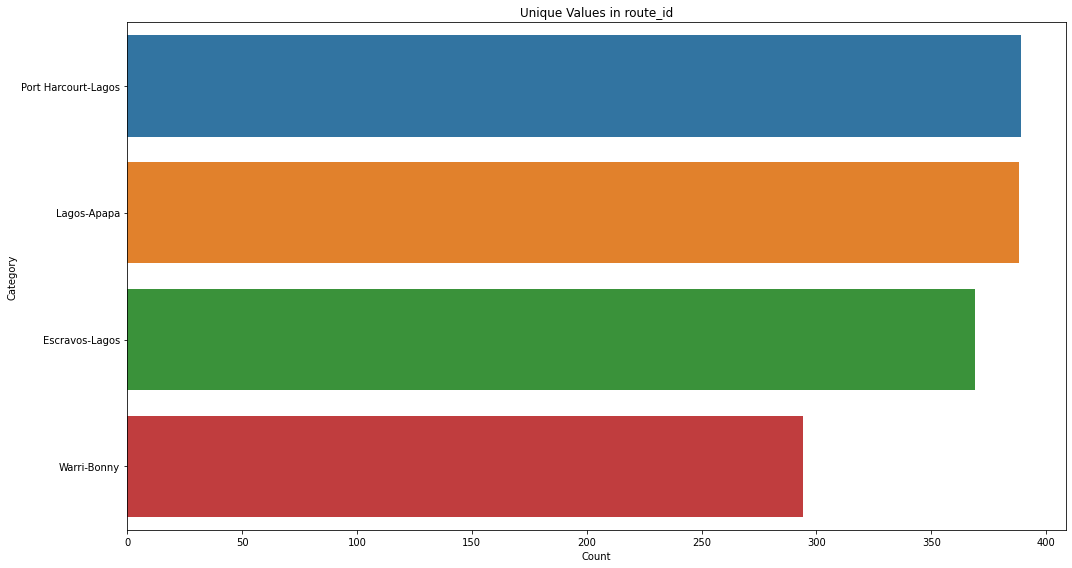

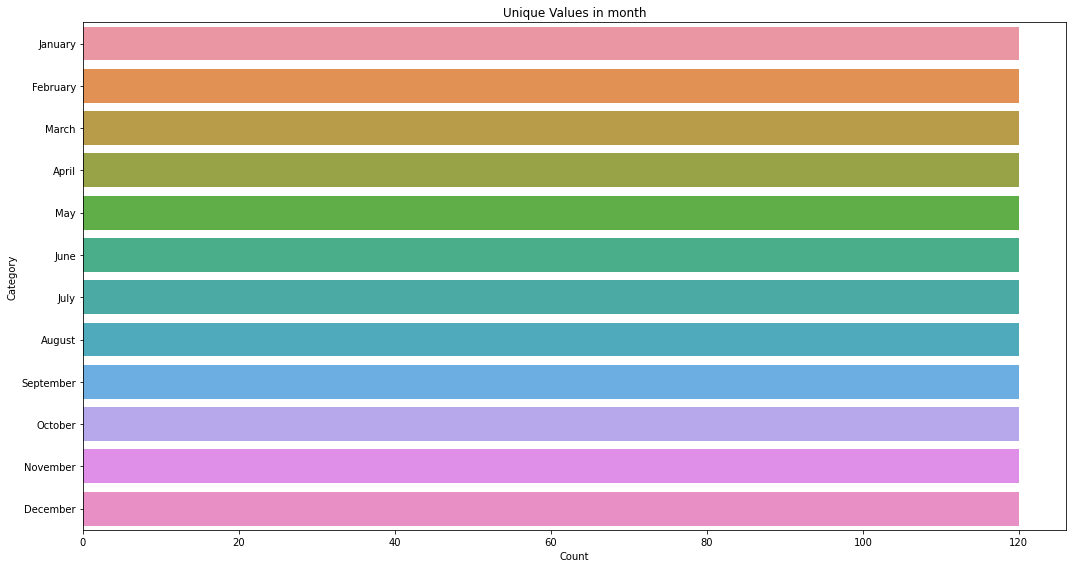

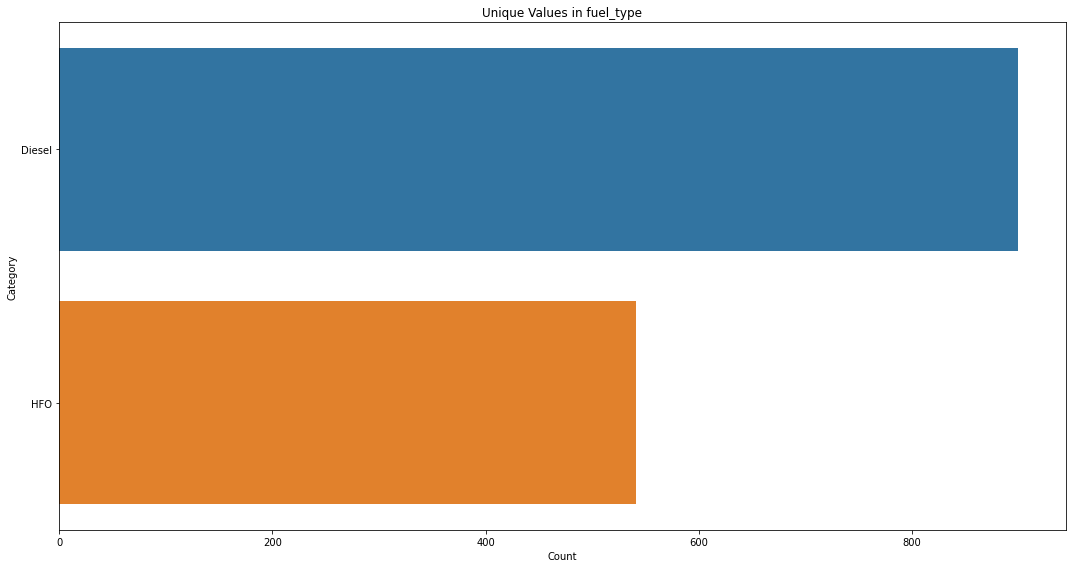

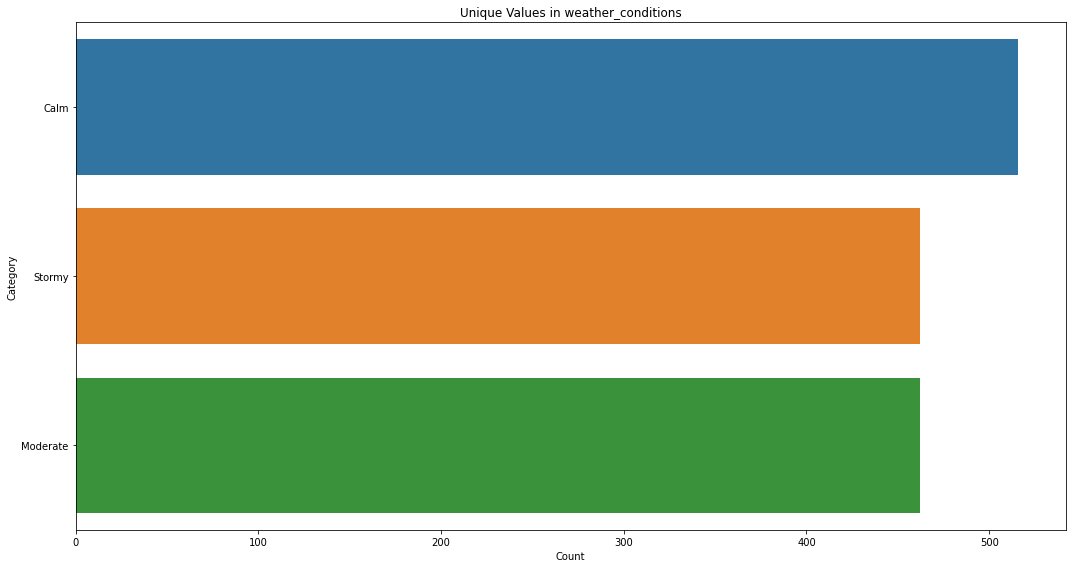

In [11]:
def plot_each_column(df: pd.DataFrame) -> None:
    """Plot count plots for each categorical column in the DataFrame"""
    categorical_columns = df.select_dtypes(include=['object']).columns
    
    for col in categorical_columns:
        plt.figure(figsize=(15, 8))
        sns.countplot(y=col, data=df, order=df[col].value_counts().index)
        plt.title(f'Unique Values in {col}')
        plt.ylabel('Category')
        plt.xlabel('Count')
        plt.tight_layout()
        plt.show()

plot_each_column(df)

In [12]:
unique_df.column

0               ship_id
1             ship_type
2              route_id
3                 month
4             fuel_type
5    weather_conditions
Name: column, dtype: object

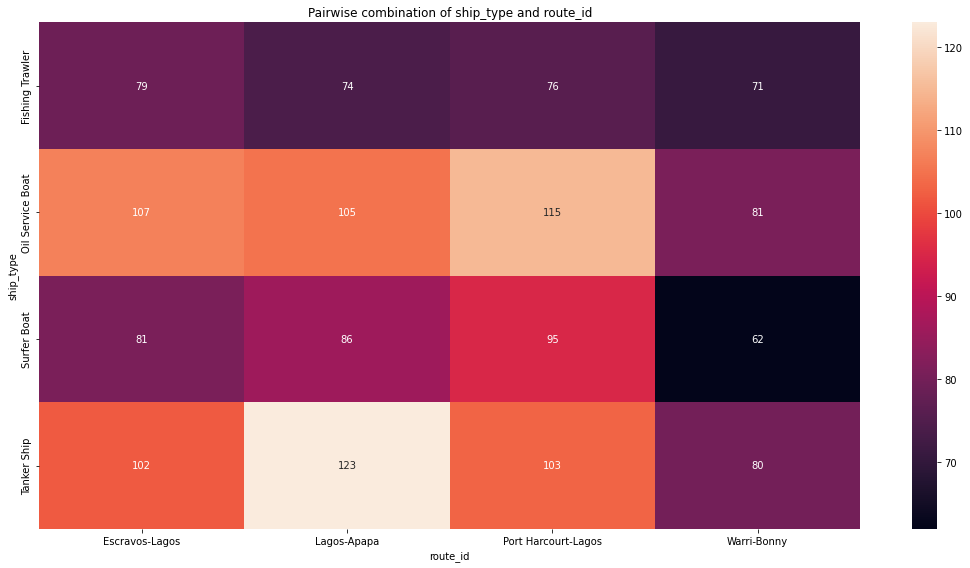

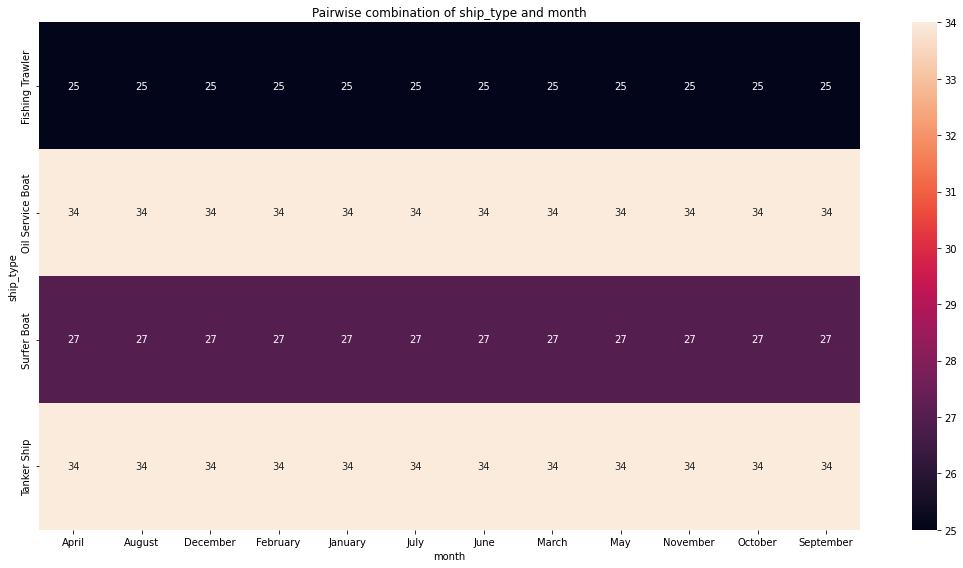

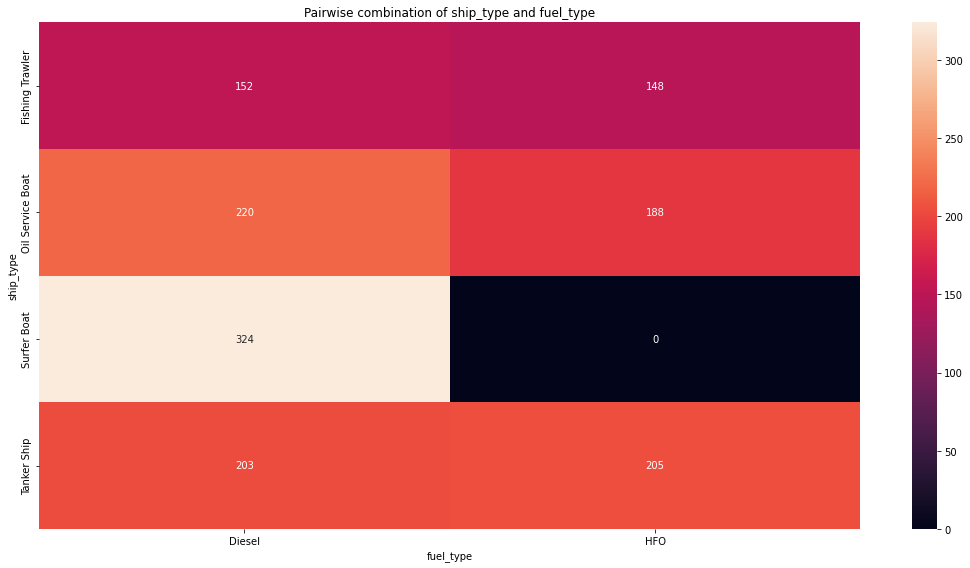

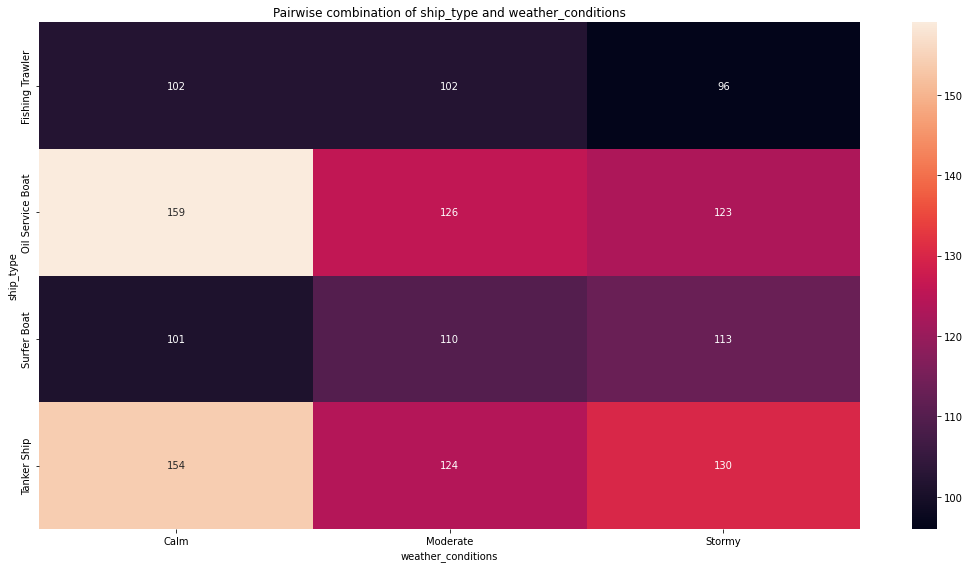

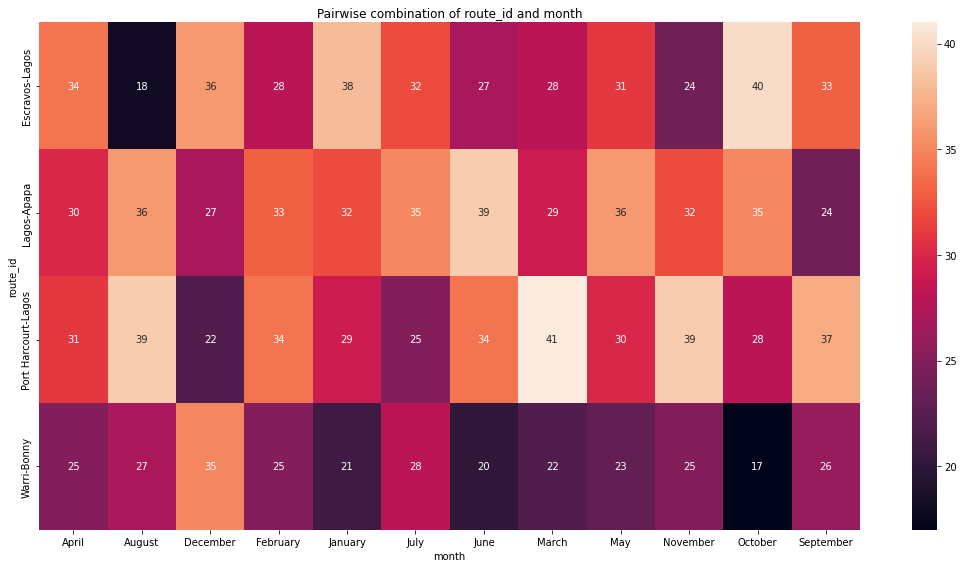

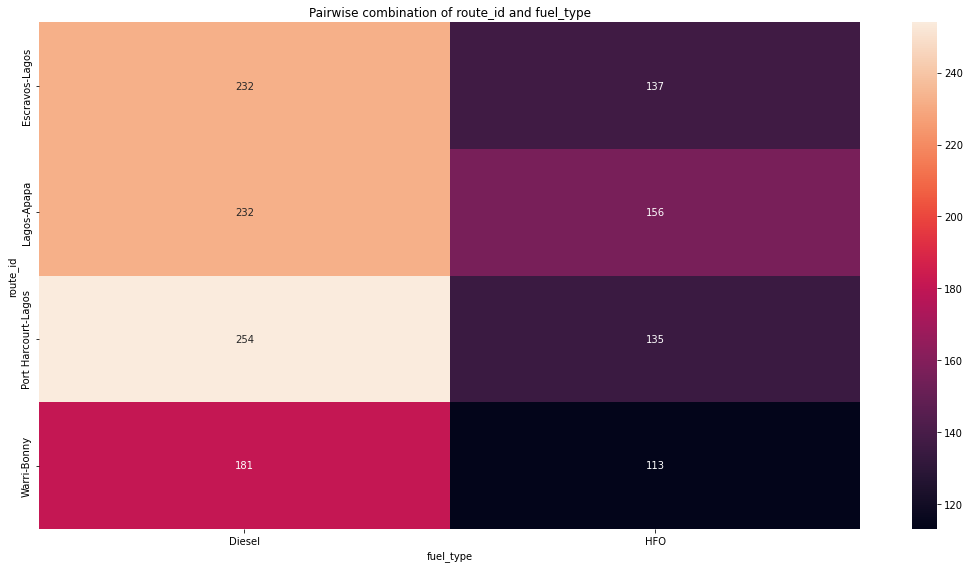

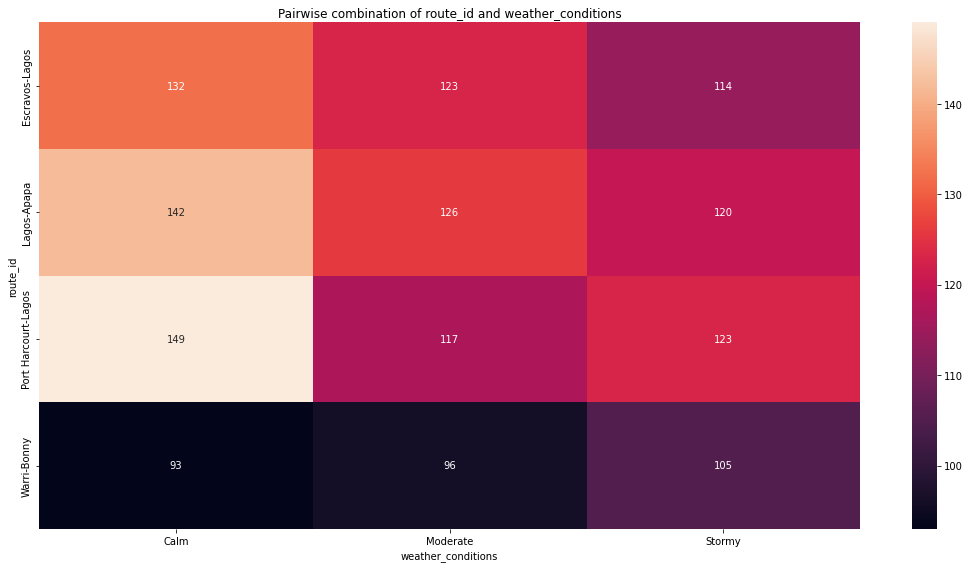

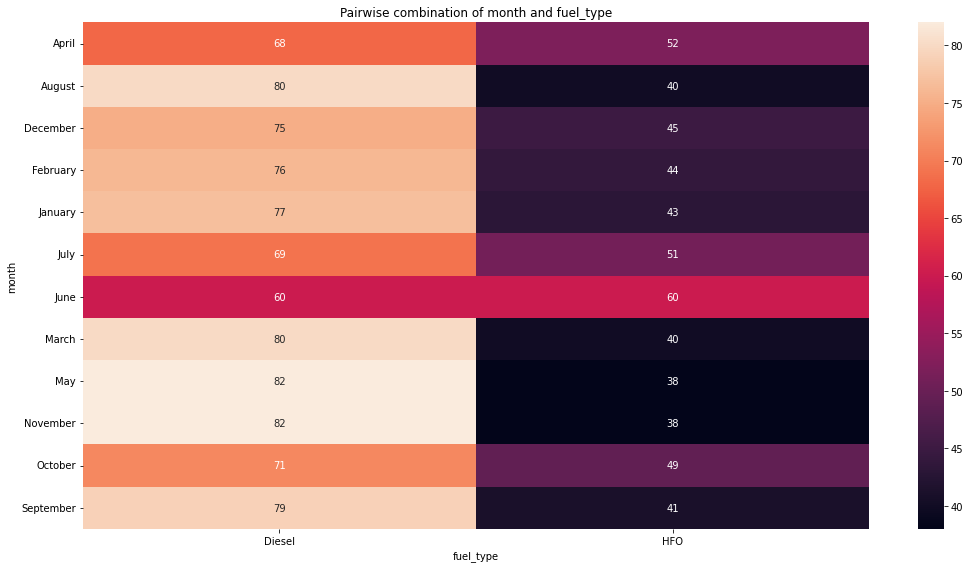

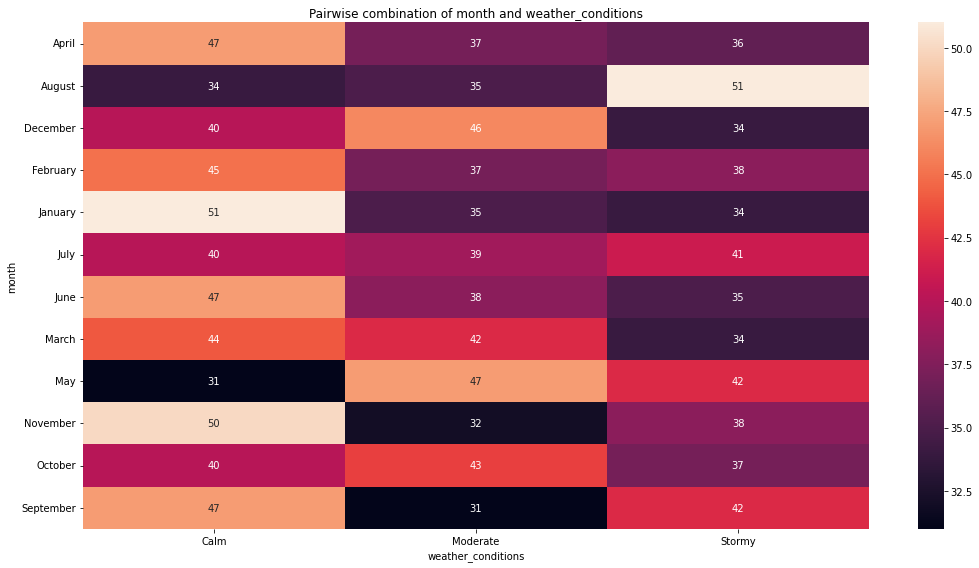

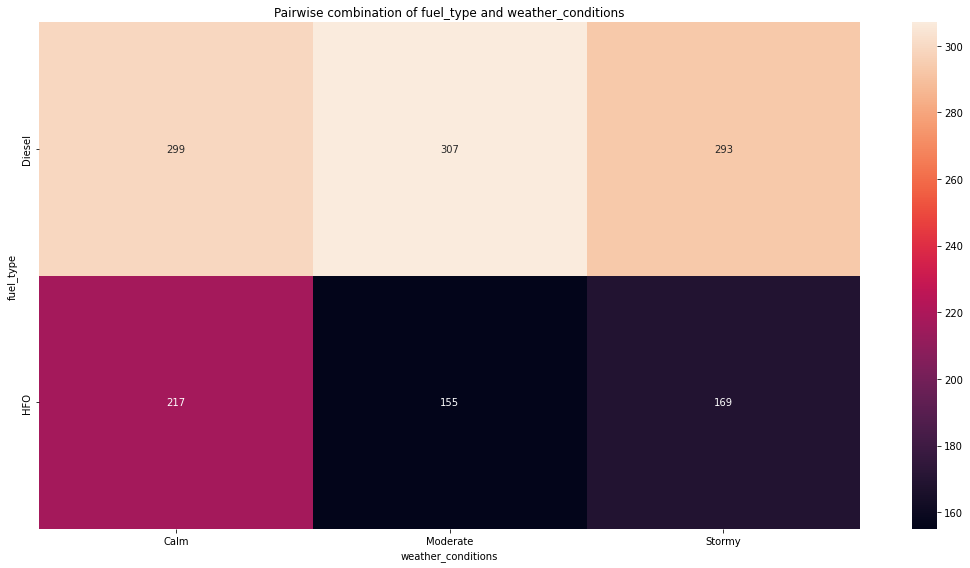

In [13]:
from itertools import combinations

def plot_pairwise_combinations(df: pd.DataFrame) -> None:
    """
    Plot pairwise combinations of categorical columns in the DataFrame
    """

    cat_columns = df.select_dtypes(include=['object']).columns.drop('ship_id') # exclude 'ship_id'
    for col1, col2 in combinations(cat_columns, 2):
        plt.figure(figsize=(15, 8))
        sns.heatmap(pd.crosstab(df[col1], df[col2]), annot=True, fmt='d')
        plt.title(f'Pairwise combination of {col1} and {col2}')
        plt.xlabel(col2)
        plt.ylabel(col1)
        plt.tight_layout()
        plt.show()

plot_pairwise_combinations(df)

### EDA - Numerical vs Numerical

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ship_id             1440 non-null   object 
 1   ship_type           1440 non-null   object 
 2   route_id            1440 non-null   object 
 3   month               1440 non-null   object 
 4   distance            1440 non-null   float64
 5   fuel_type           1440 non-null   object 
 6   fuel_consumption    1440 non-null   float64
 7   CO2_emissions       1440 non-null   float64
 8   weather_conditions  1440 non-null   object 
 9   engine_efficiency   1440 non-null   float64
dtypes: float64(4), object(6)
memory usage: 112.6+ KB


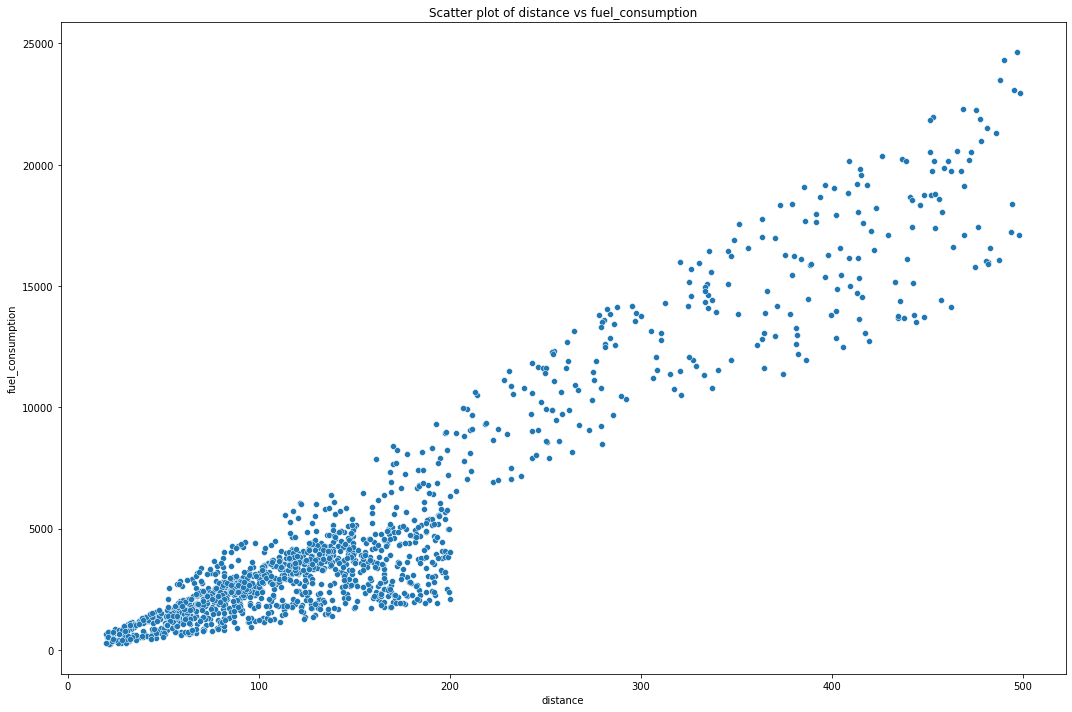

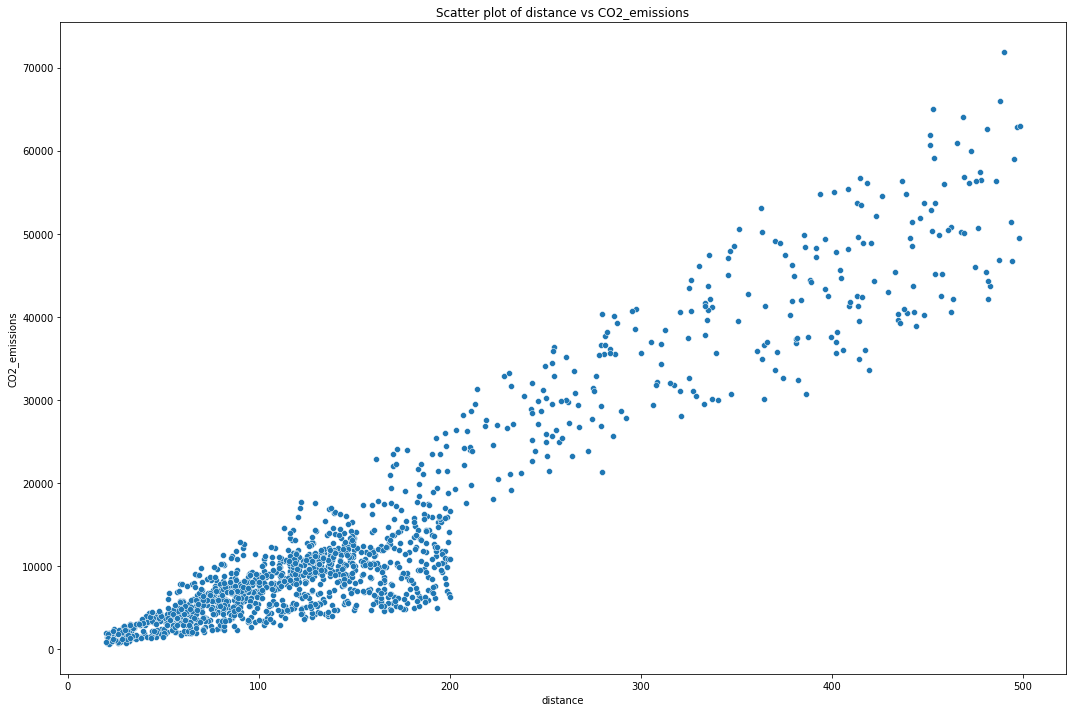

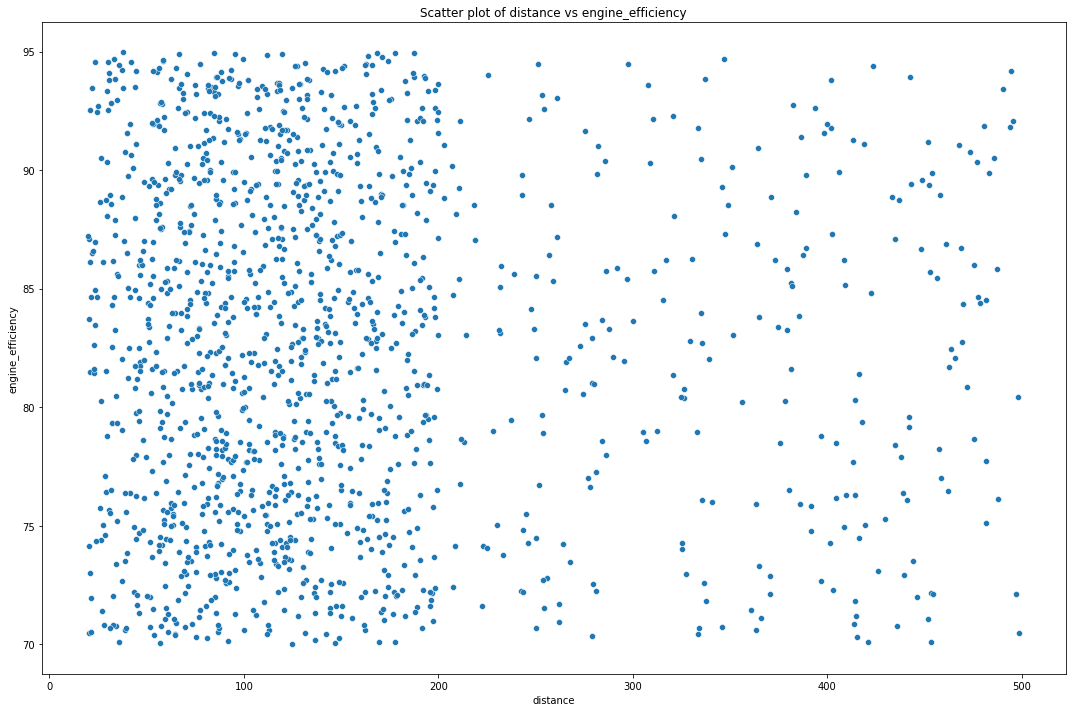

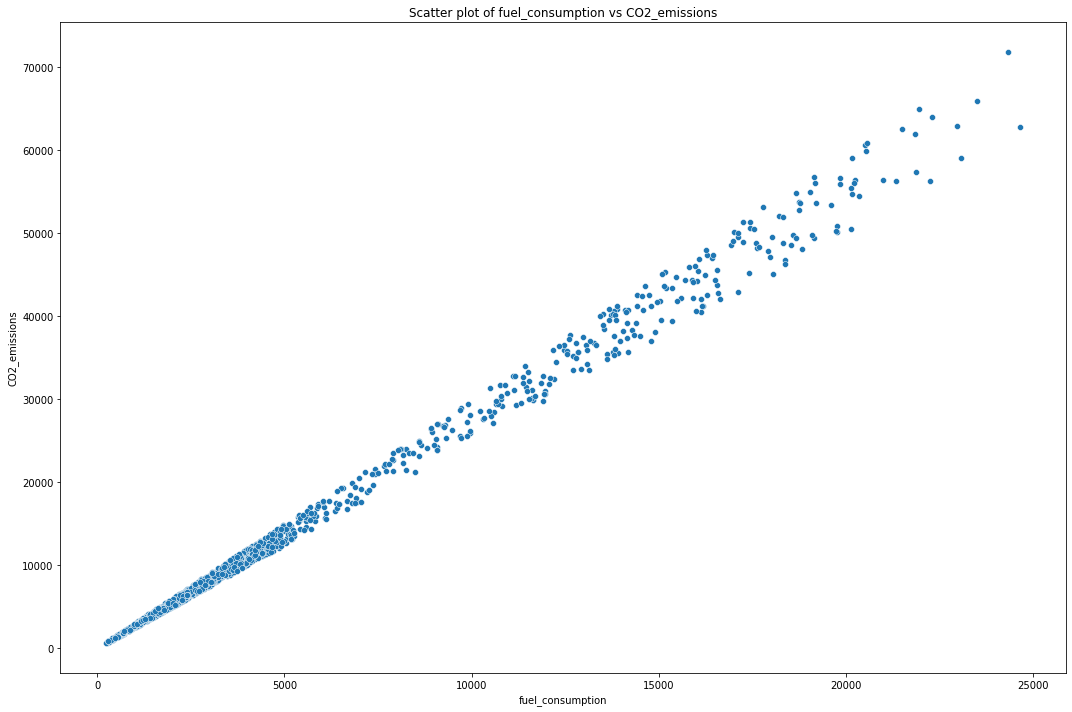

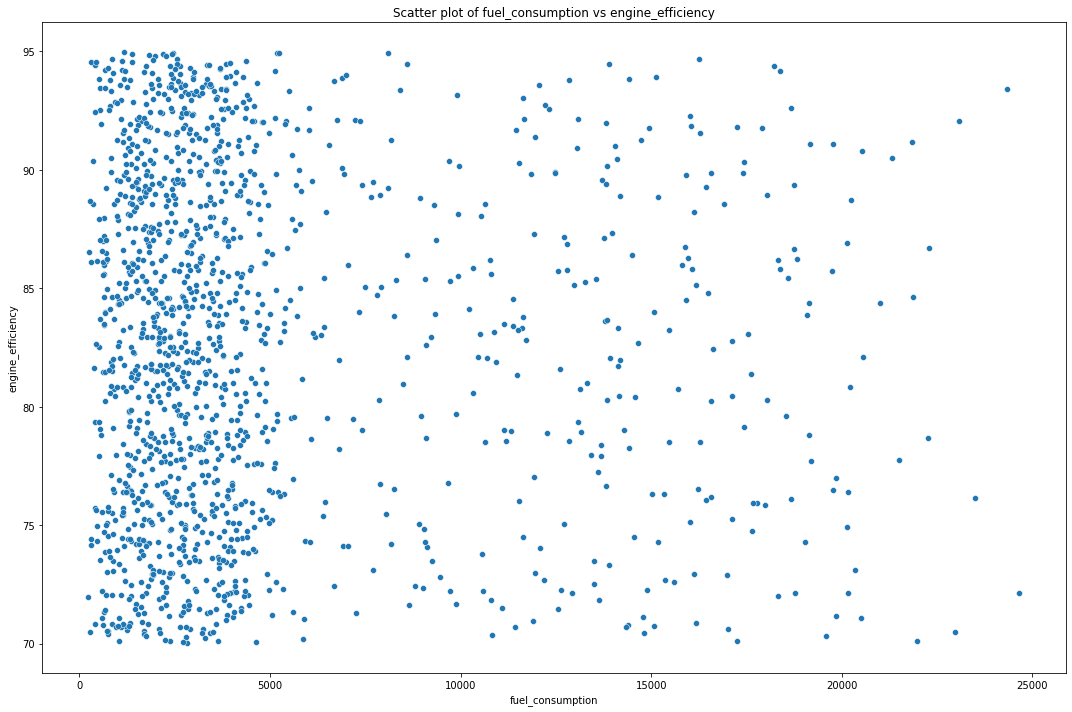

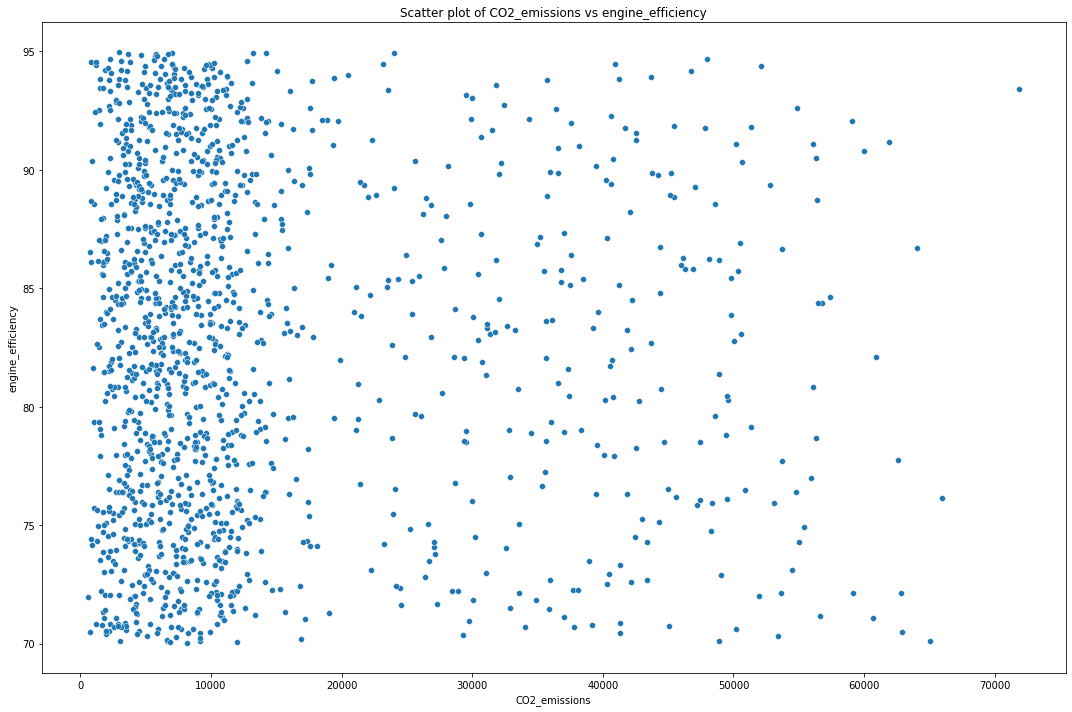

In [15]:
def plot_numerical_columns(df: pd.DataFrame) -> None:
    """
    plot numerical columns in the DataFrame
    """
    num_columns = df.select_dtypes(include=['float64']).columns
    for col1, col2 in combinations(num_columns, 2):
        plt.figure(figsize=(15, 10))
        sns.scatterplot(x=col1, y=col2, data=df)
        plt.title(f'Scatter plot of {col1} vs {col2}')
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.tight_layout()
        plt.show()

plot_numerical_columns(df)

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: us

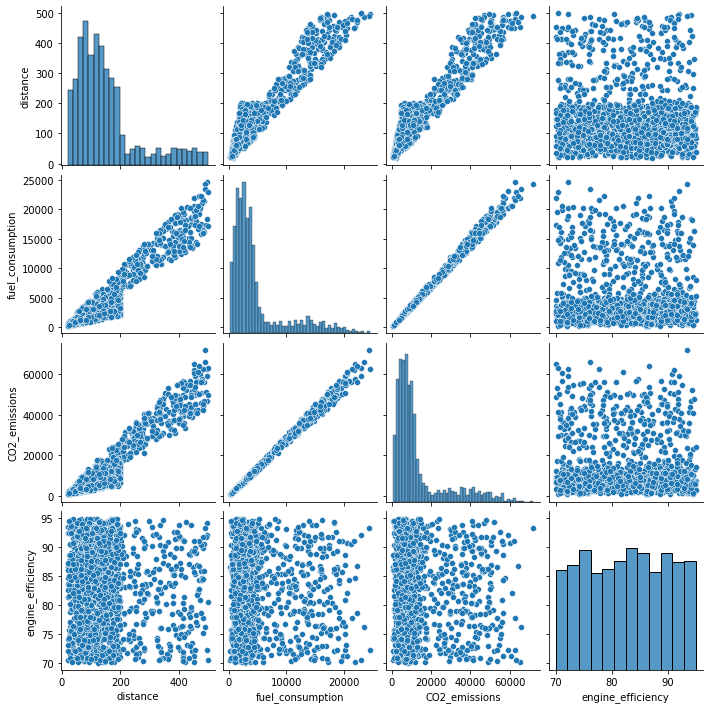

In [16]:
sns.pairplot(df.select_dtypes(include=['float64']))

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


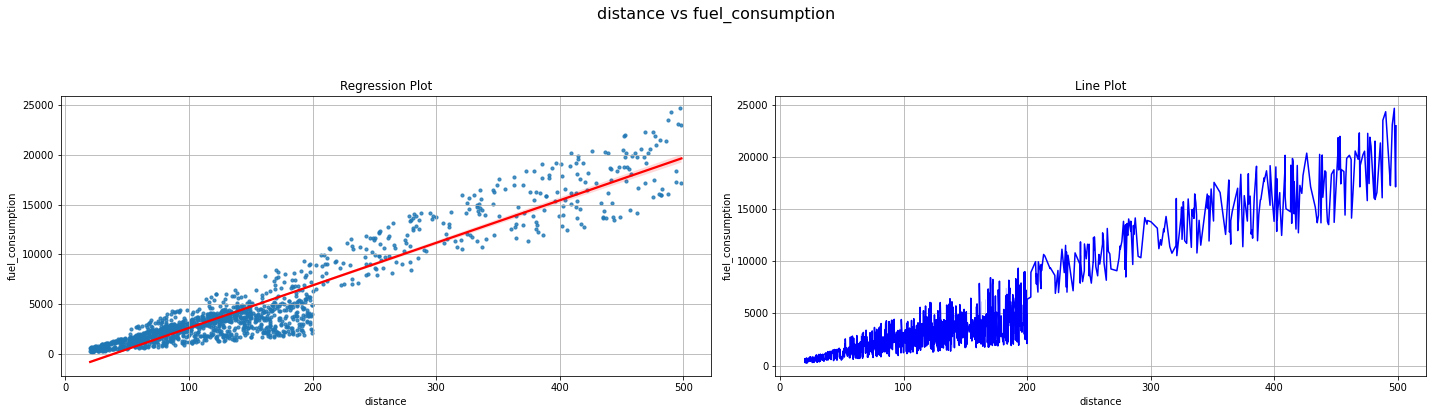

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


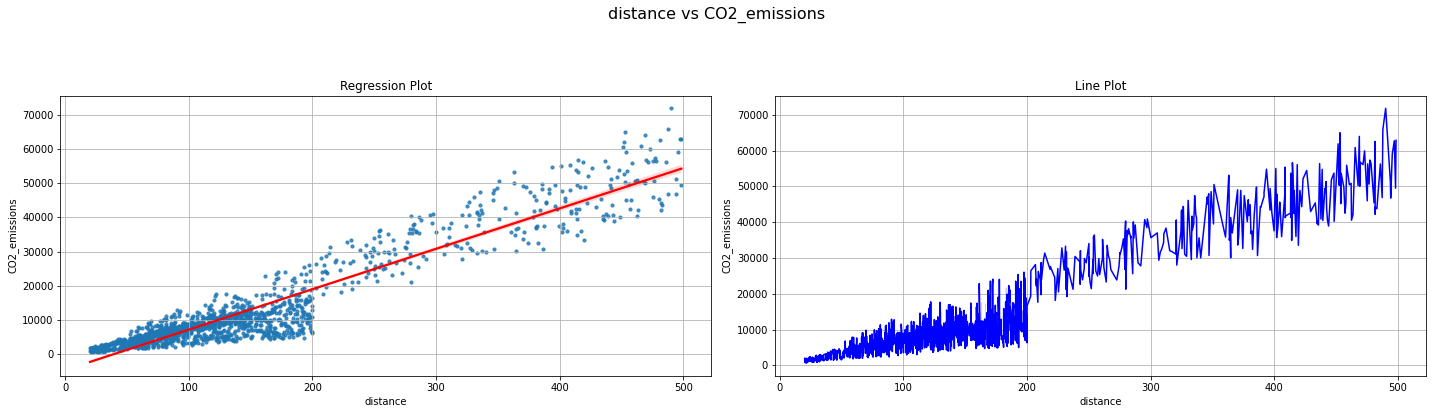

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


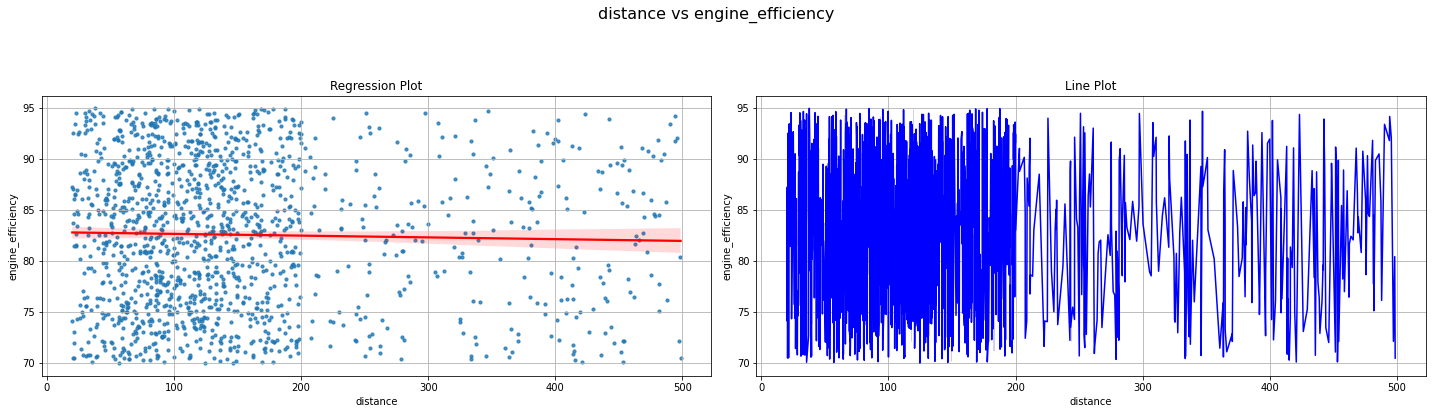

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


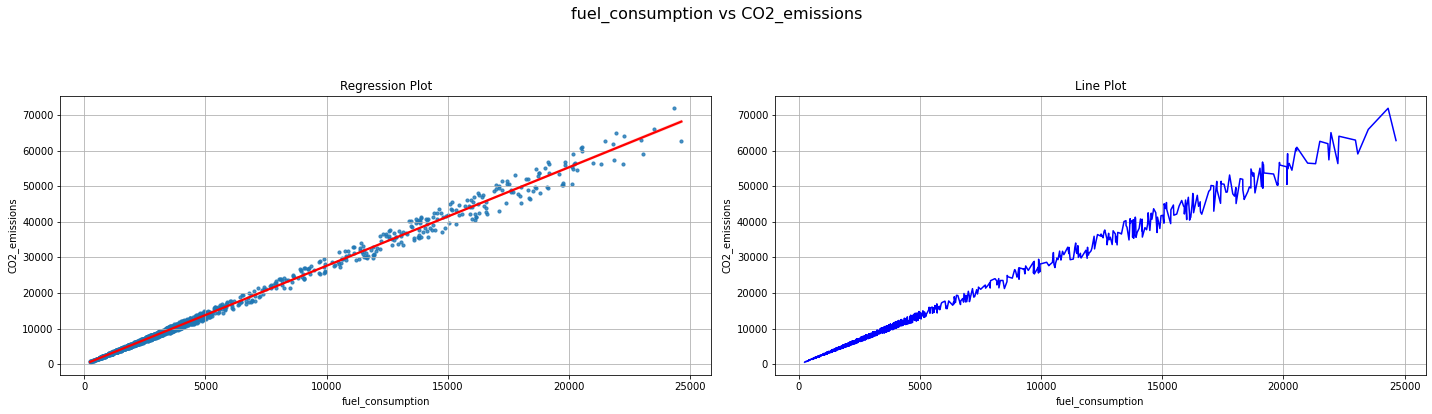

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


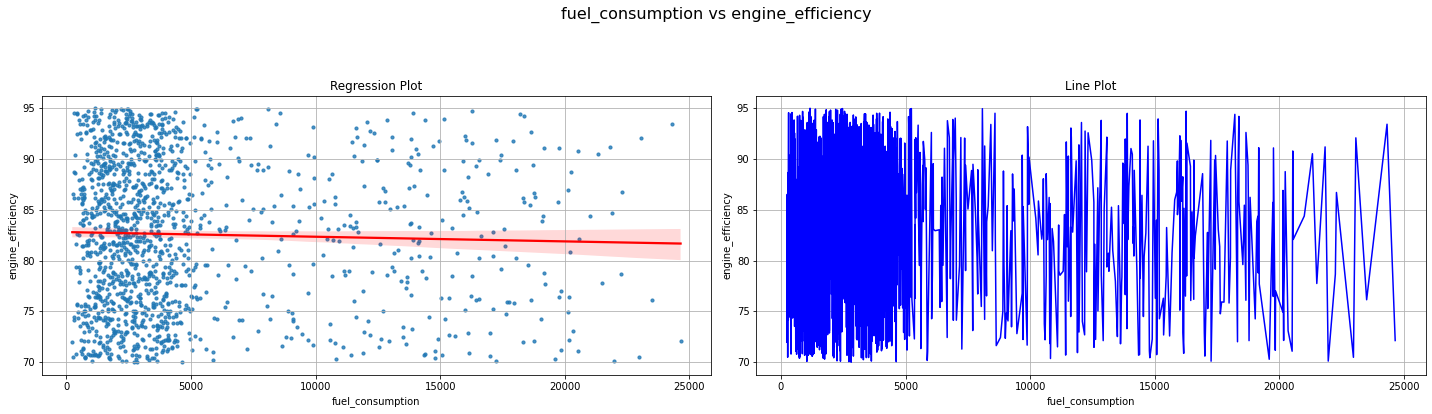

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


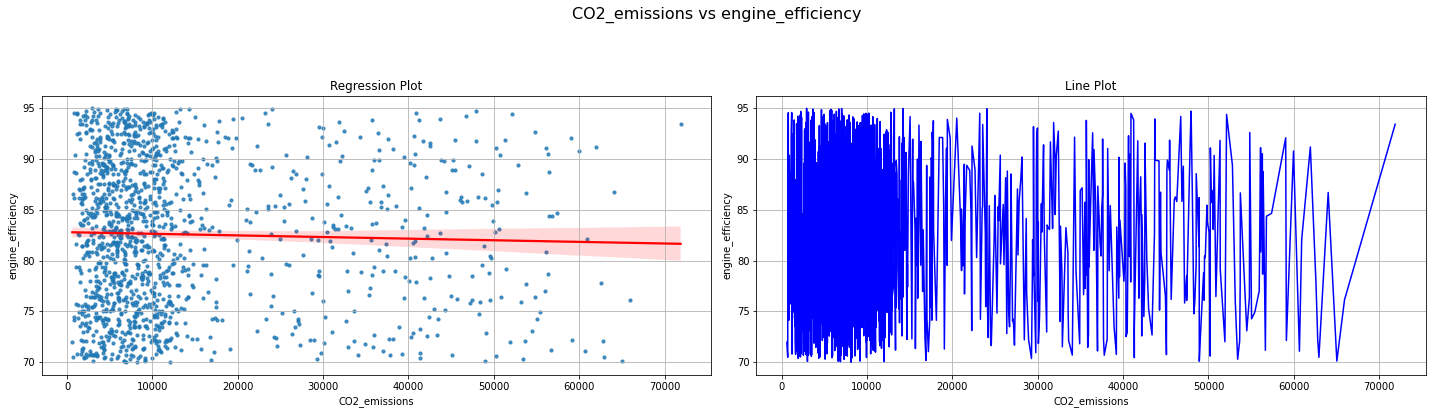

In [17]:
def plot_all_numerical_combinations(df: pd.DataFrame) -> None:
    """
    Plot all combinations of numerical columns.
    For each pair of numerical columns, plot:
    - regplot (trend line)
    - line plot
    All side-by-side in one figure.
    """
    num_columns = df.select_dtypes(include=['float64']).columns
    num_combinations = list(combinations(num_columns, 2))
    for col1, col2 in num_combinations:
        fig, axes = plt.subplots(1, 2, figsize=(20, 6))
        fig.suptitle(f'{col1} vs {col2}', fontsize=16)

        # regplot
        sns.regplot(x=df[col1], y=df[col2], ax=axes[0], scatter_kws={'s': 10}, line_kws={'color': 'red'})
        axes[0].set_title('Regression Plot')
        axes[0].set_xlabel(col1)
        axes[0].set_ylabel(col2)

        # Line Plot
        sns.lineplot(x=df[col1], y=df[col2], ax=axes[1], color='blue')
        axes[1].set_title('Line Plot')
        axes[1].set_xlabel(col1)
        axes[1].set_ylabel(col2)

        for ax in axes:
            ax.grid(True)
        plt.tight_layout(rect=[0, 0.03, 1, 0.90])
        plt.show()

plot_all_numerical_combinations(df)

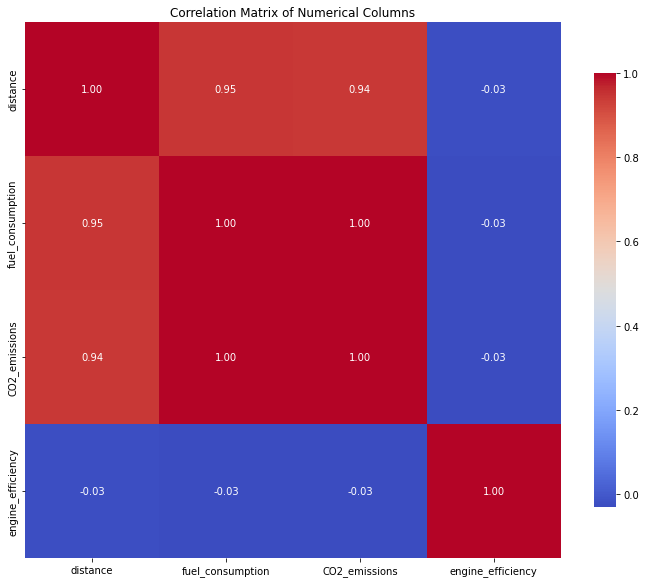

In [18]:
# correlation matrix
def plot_correlation_matrix(df: pd.DataFrame) -> None:
    """
    Plot the correlation matrix of numerical columns
    """

    corr = df.select_dtypes(include=['float64']).corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={'shrink': .8})
    plt.title('Correlation Matrix of Numerical Columns')
    plt.show()

plot_correlation_matrix(df)

### EDA Categorical - Two Targets

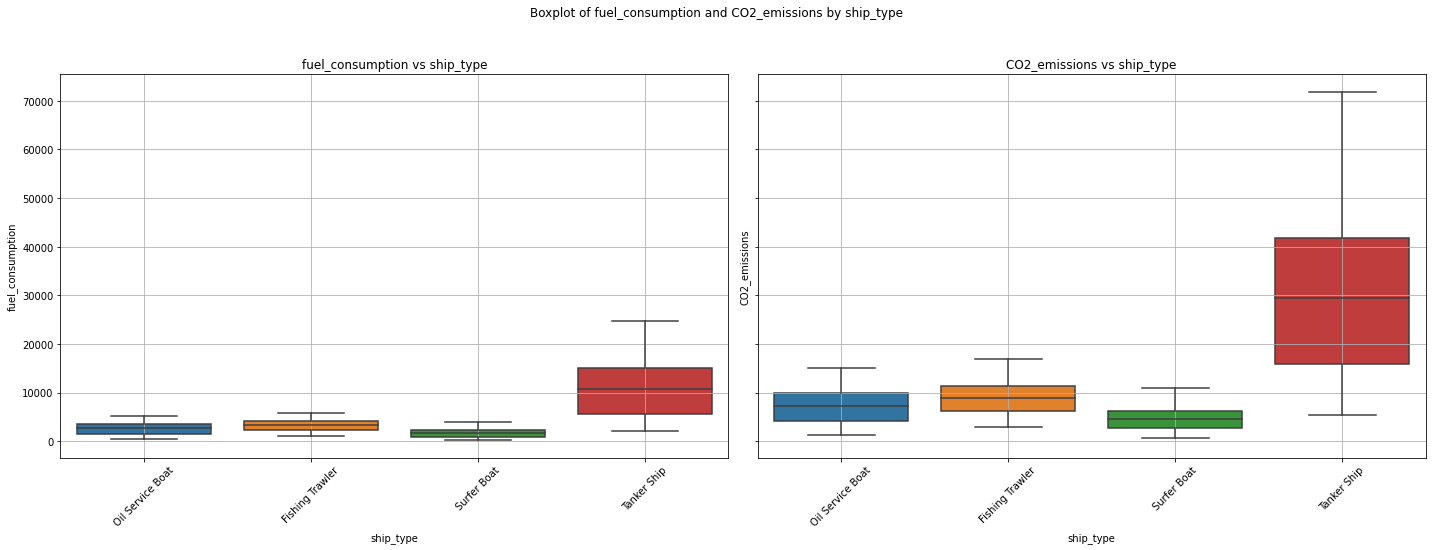

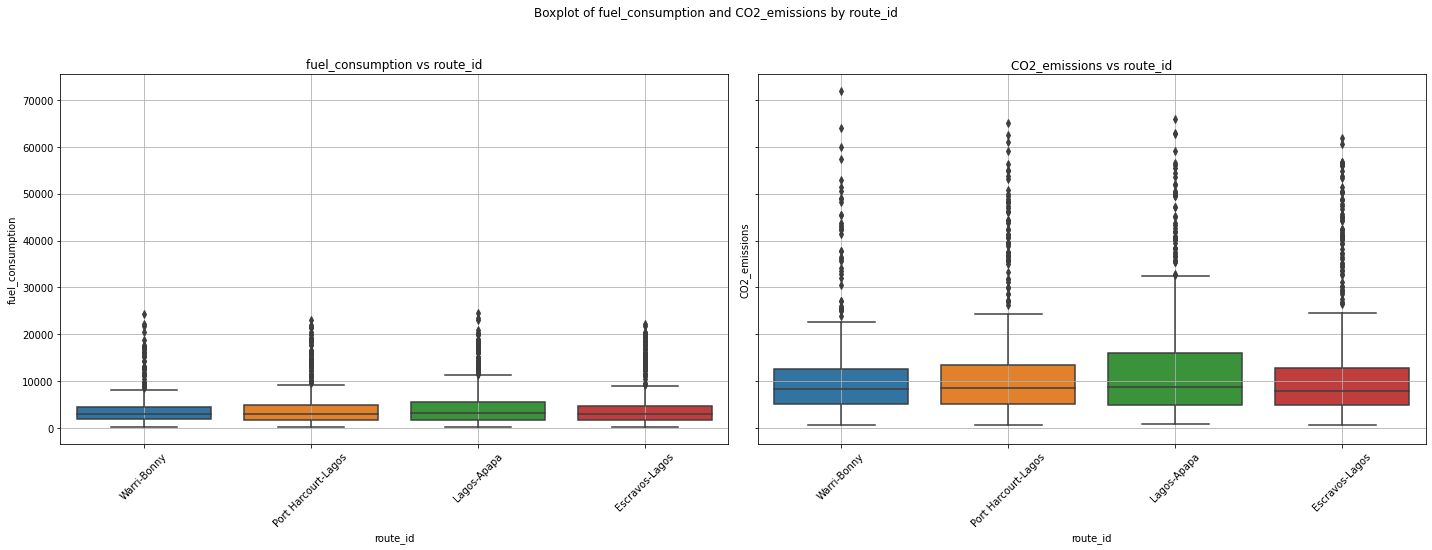

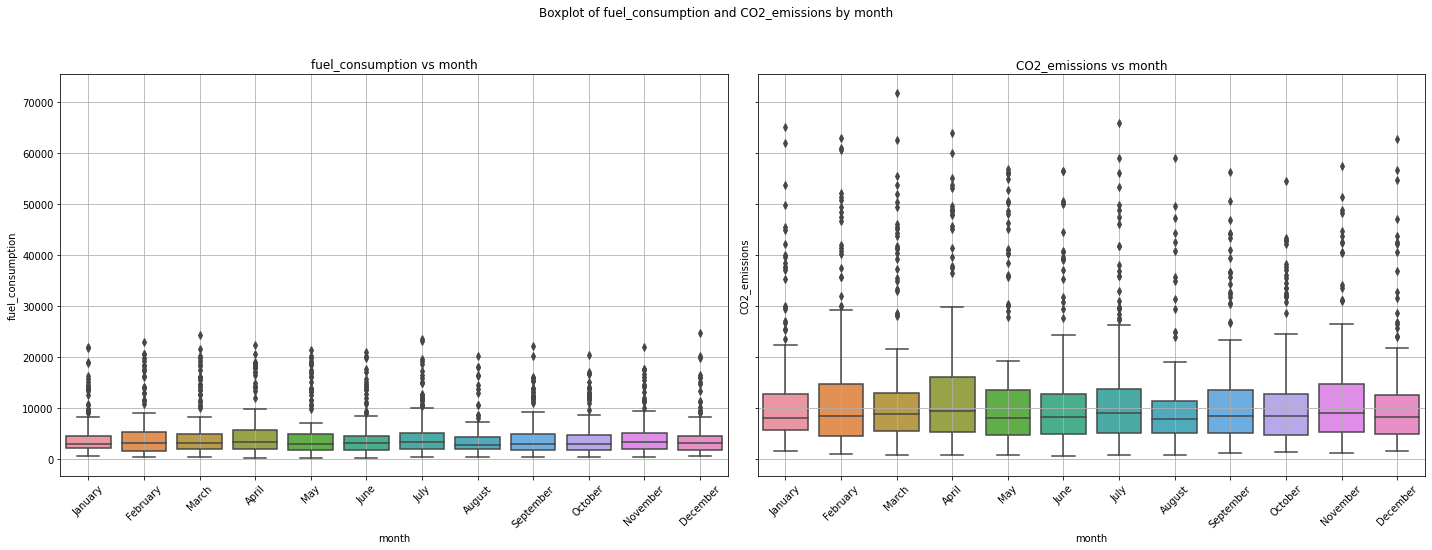

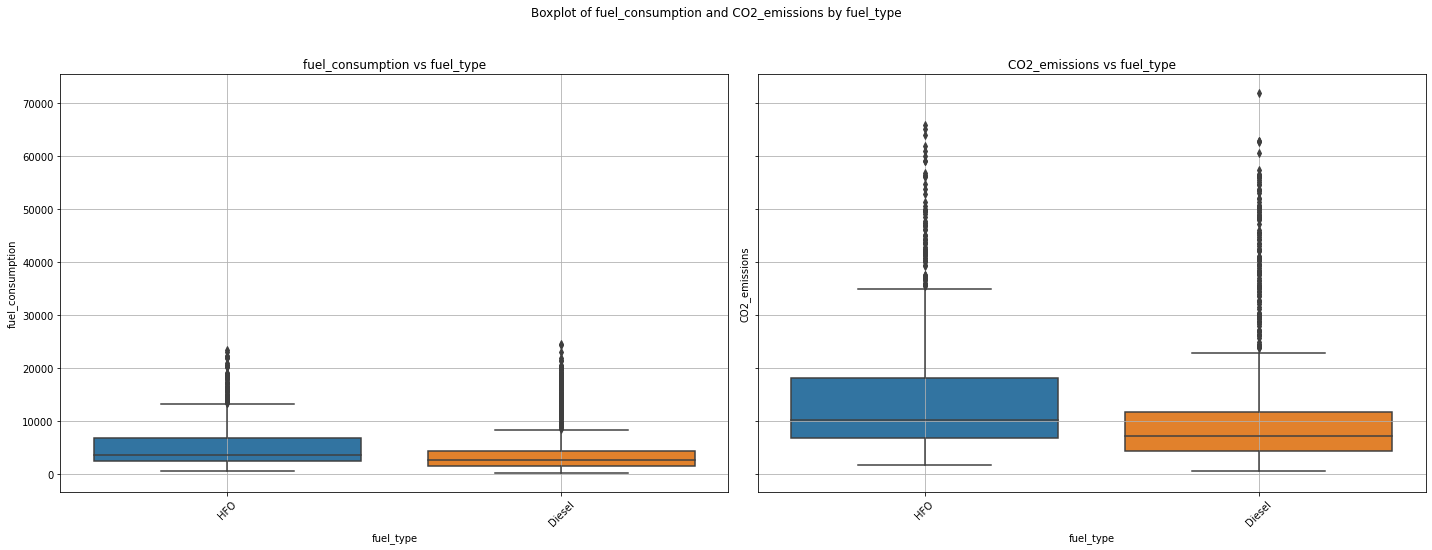

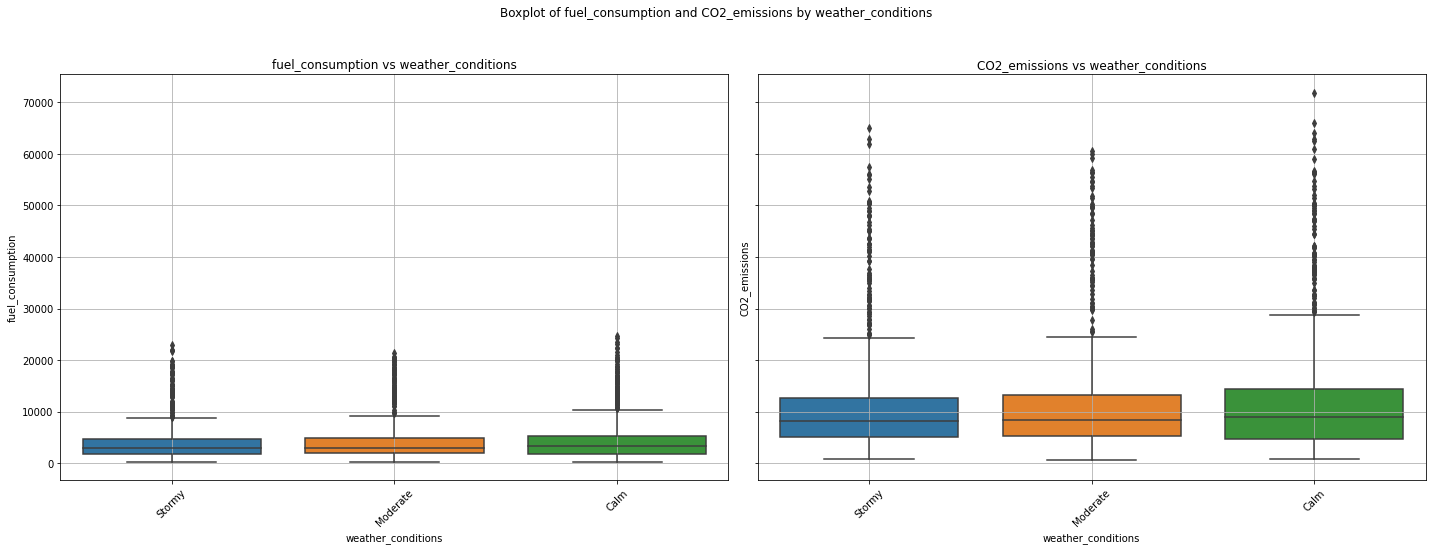

In [19]:
def plot_boxplots(df: pd.DataFrame) -> None:
    """
    Plot side-by-side boxplots for categrical columns against fuel_consumption and CO2_emission
    """

    cat_columns = df.select_dtypes(include=['object']).columns.drop('ship_id')
    target_columns = ['fuel_consumption', 'CO2_emissions']
    for cat_col in cat_columns:
        fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
        fig.suptitle(f'Boxplot of {target_columns[0]} and {target_columns[1]} by {cat_col}')

        for i, target_col in enumerate(target_columns):
            sns.boxplot(x=cat_col, y=target_col, data=df, ax=axes[i])
            axes[i].set_title(f'{target_col} vs {cat_col}')
            axes[i].set_xlabel(cat_col)
            axes[i].set_ylabel(target_col)
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].grid(True)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

plot_boxplots(df)

there's a lot of outliers actually but at the same time i want to let them be. 

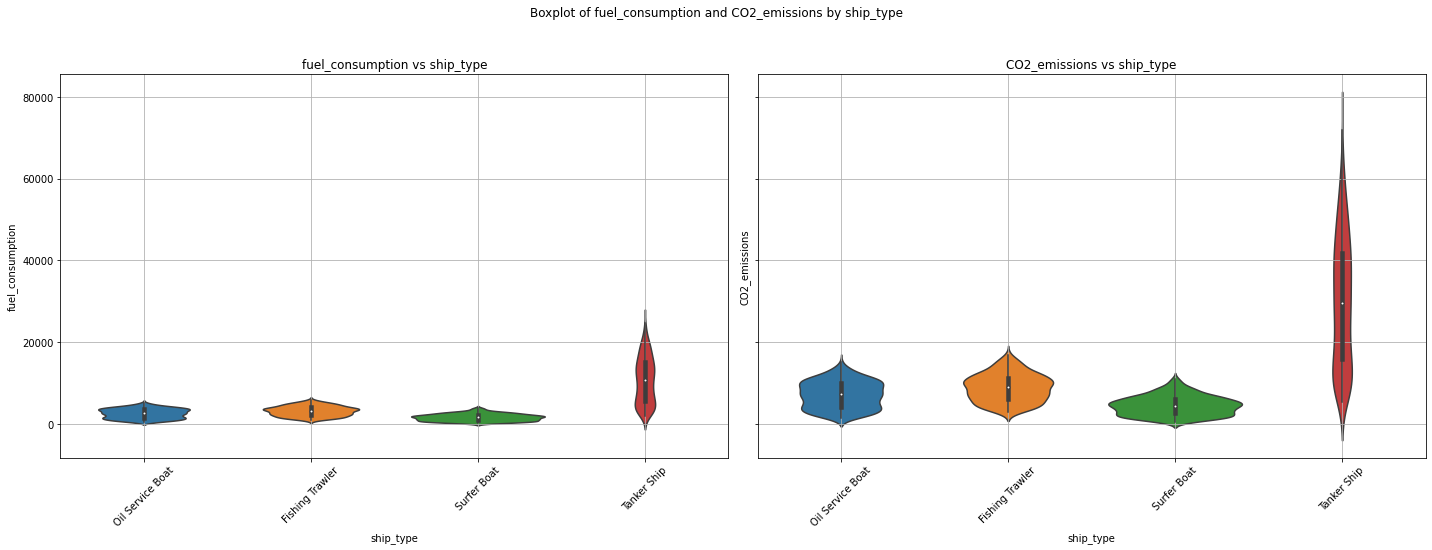

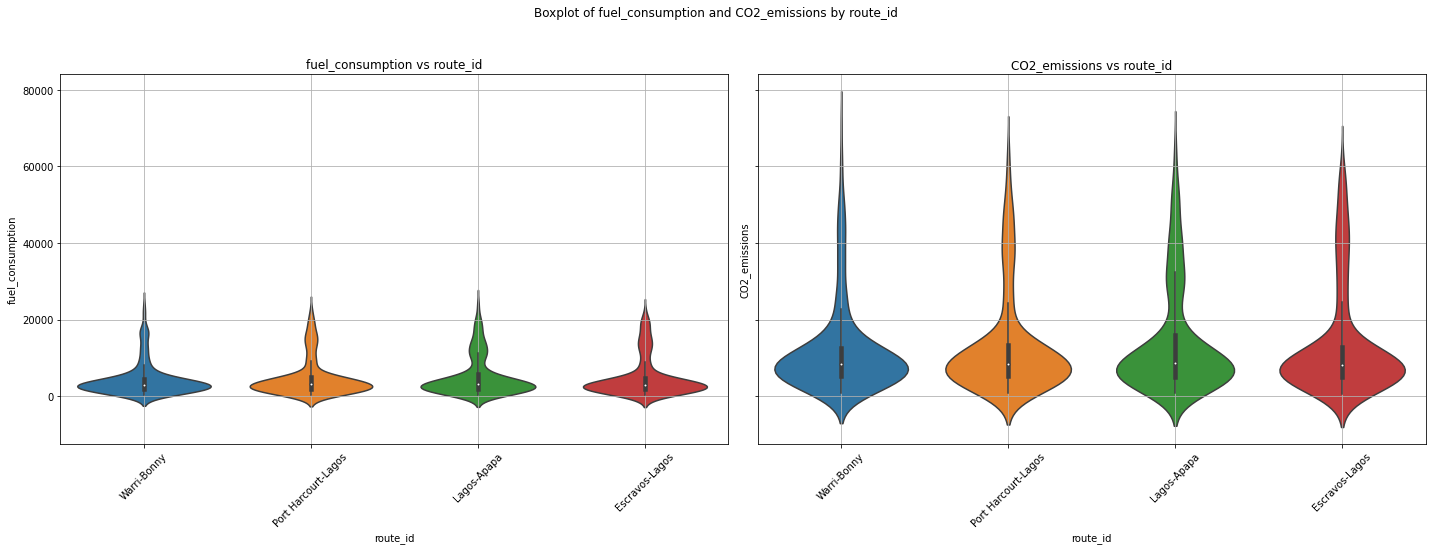

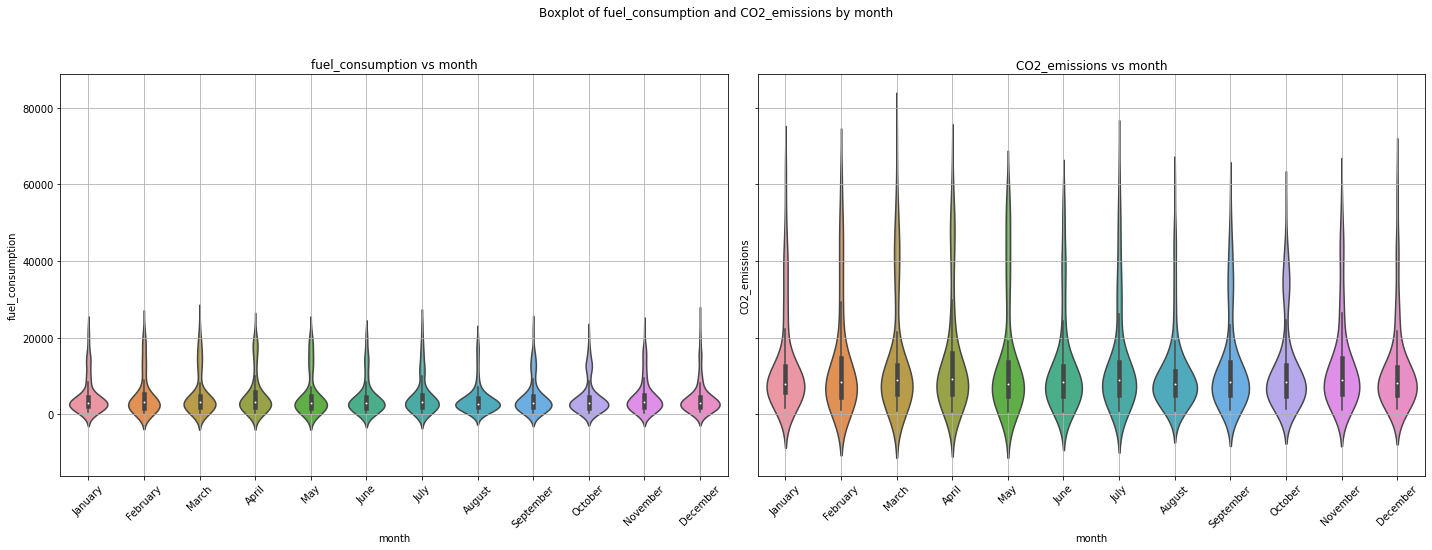

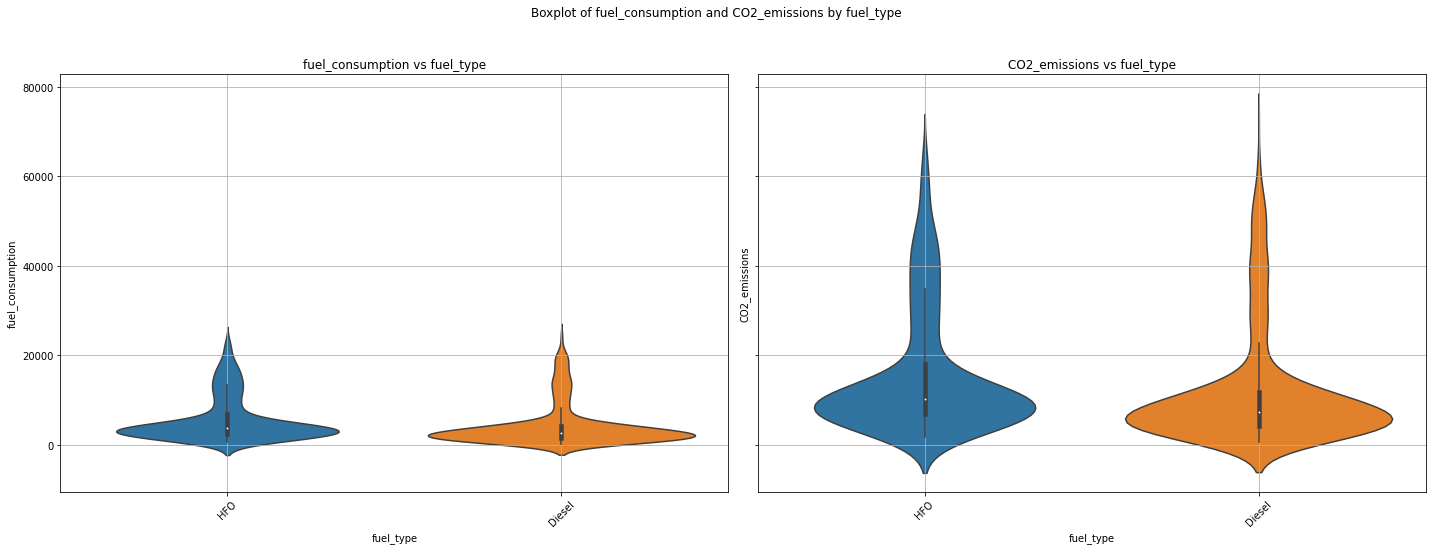

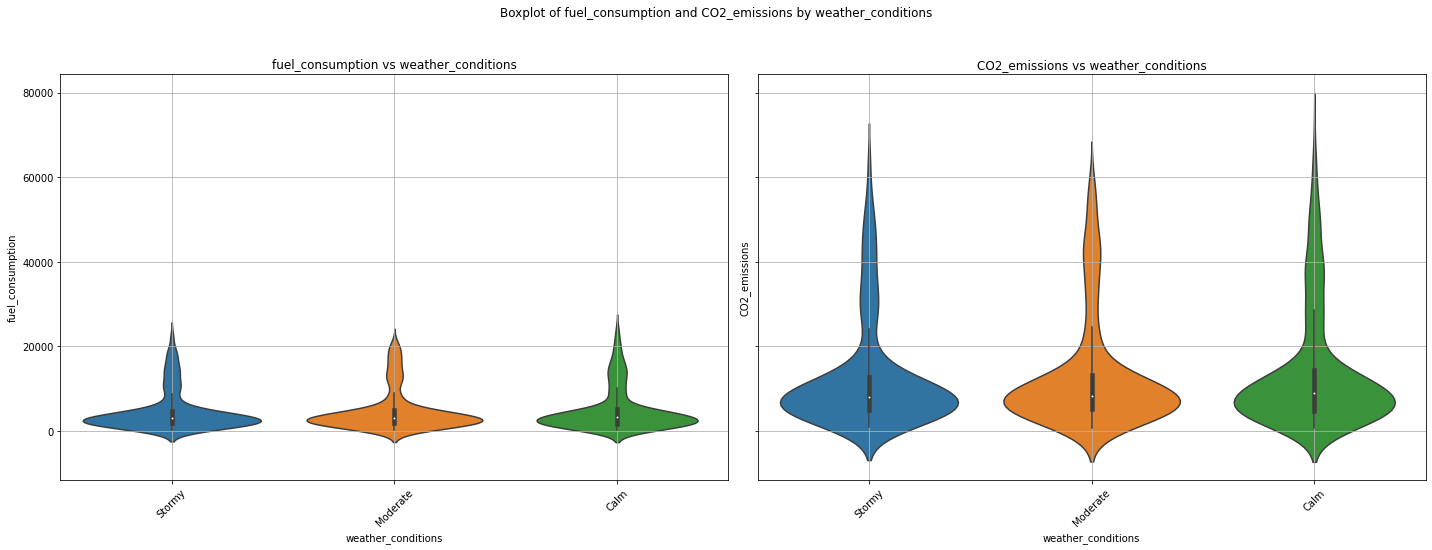

In [20]:
def plot_violinplot(df: pd.DataFrame) -> None:
    """
    Plot side-by-side violinplot for categrical columns against fuel_consumption and CO2_emission
    """

    cat_columns = df.select_dtypes(include=['object']).columns.drop('ship_id')
    target_columns = ['fuel_consumption', 'CO2_emissions']
    for cat_col in cat_columns:
        fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
        fig.suptitle(f'Boxplot of {target_columns[0]} and {target_columns[1]} by {cat_col}')

        for i, target_col in enumerate(target_columns):
            sns.violinplot(x=cat_col, y=target_col, data=df, ax=axes[i])
            axes[i].set_title(f'{target_col} vs {cat_col}')
            axes[i].set_xlabel(cat_col)
            axes[i].set_ylabel(target_col)
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].grid(True)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

plot_violinplot(df)

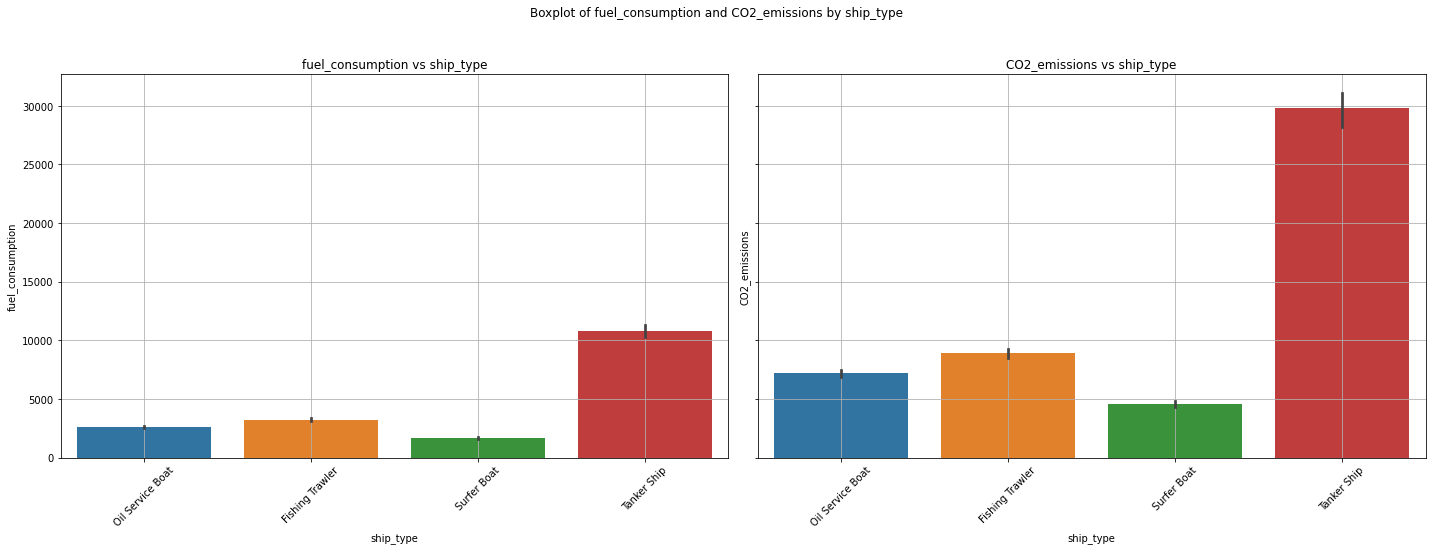

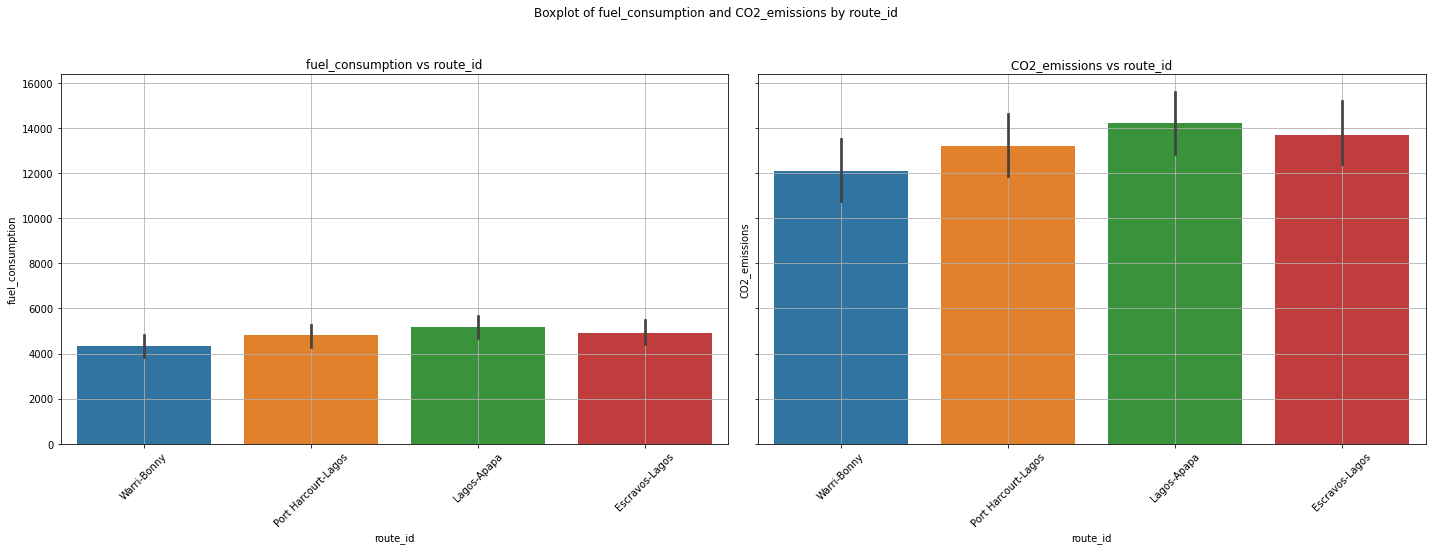

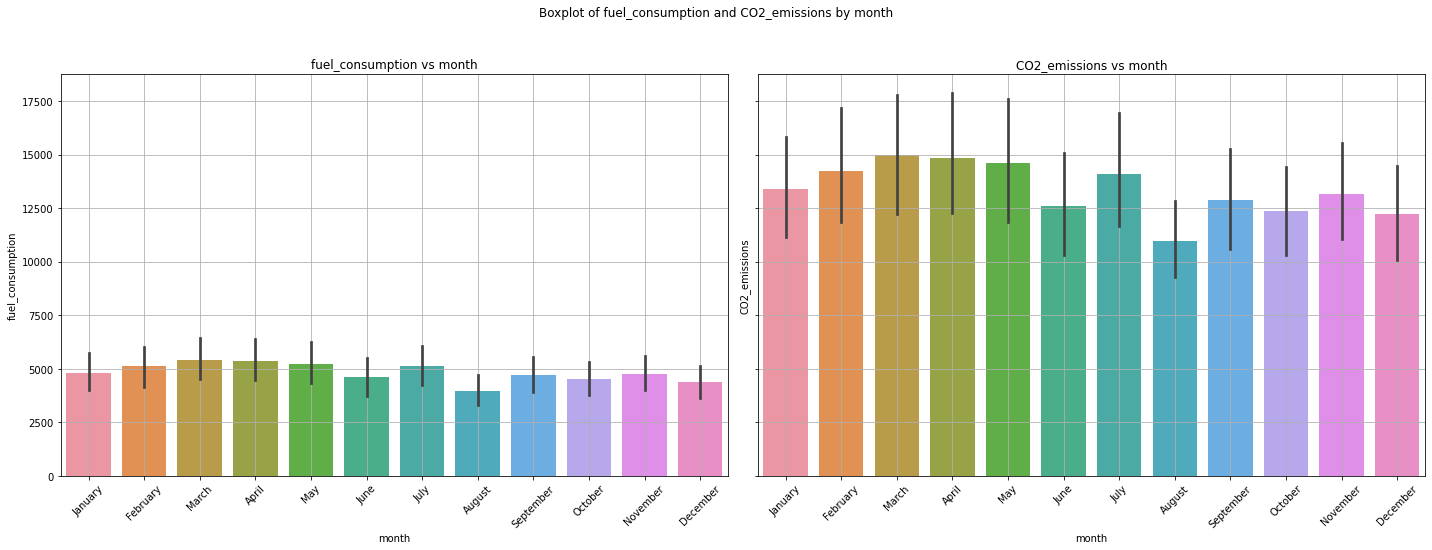

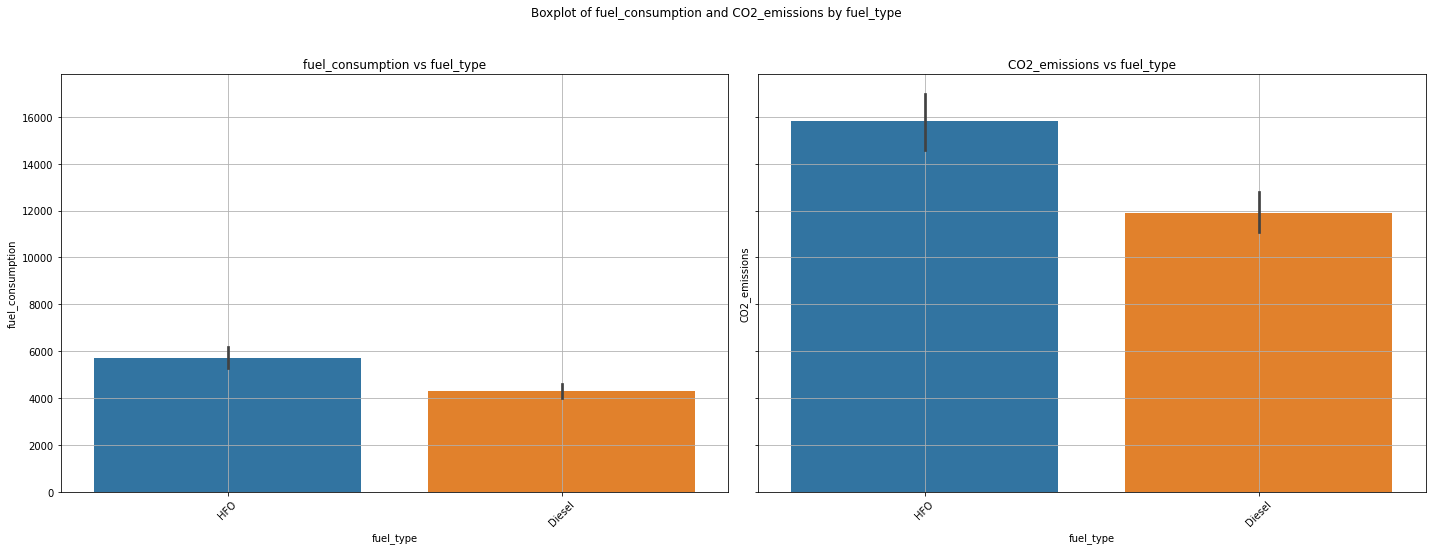

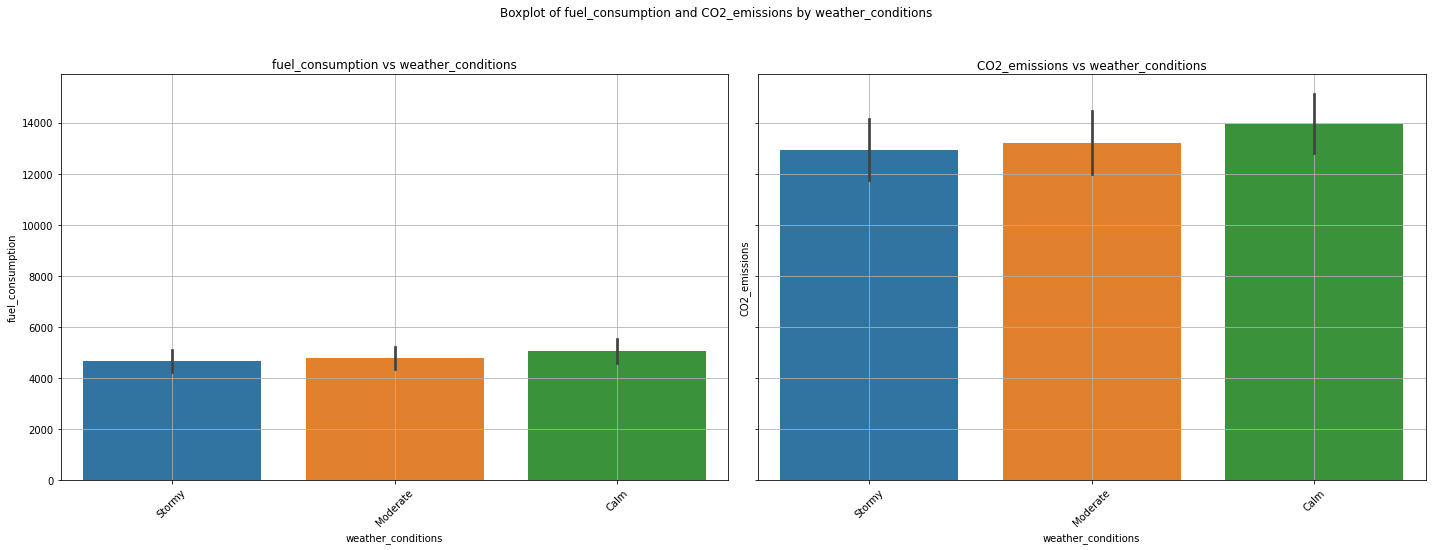

In [21]:
def plot_barplot(df: pd.DataFrame) -> None:
    """
    Plot side-by-side barplot for categrical columns against fuel_consumption and CO2_emission
    """

    cat_columns = df.select_dtypes(include=['object']).columns.drop('ship_id')
    target_columns = ['fuel_consumption', 'CO2_emissions']
    for cat_col in cat_columns:
        fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
        fig.suptitle(f'Boxplot of {target_columns[0]} and {target_columns[1]} by {cat_col}')

        for i, target_col in enumerate(target_columns):
            sns.barplot(x=cat_col, y=target_col, data=df, ax=axes[i])
            axes[i].set_title(f'{target_col} vs {cat_col}')
            axes[i].set_xlabel(cat_col)
            axes[i].set_ylabel(target_col)
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].grid(True)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

plot_barplot(df)

bonus categorical vs numerical

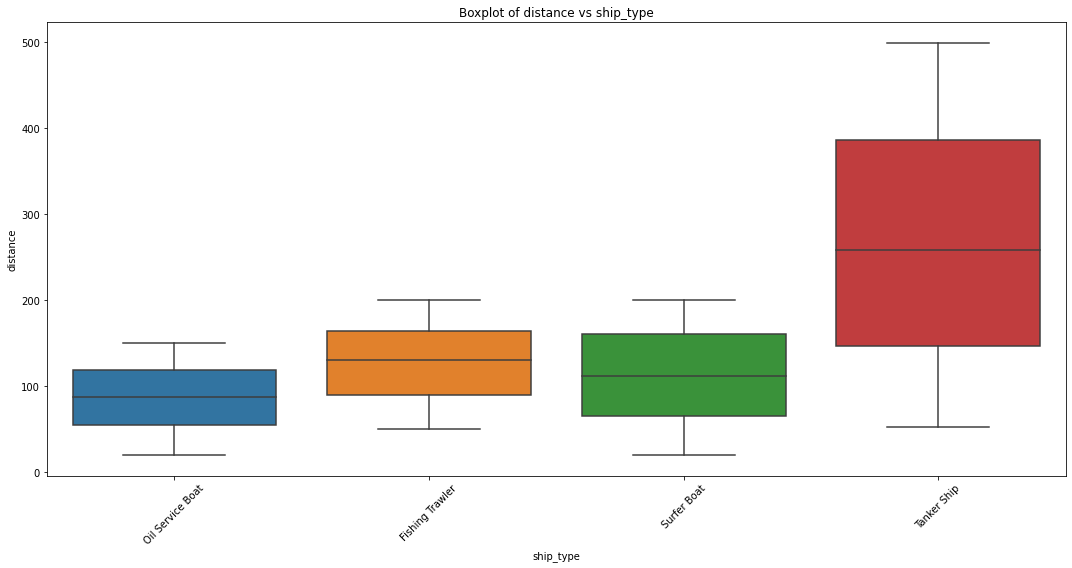

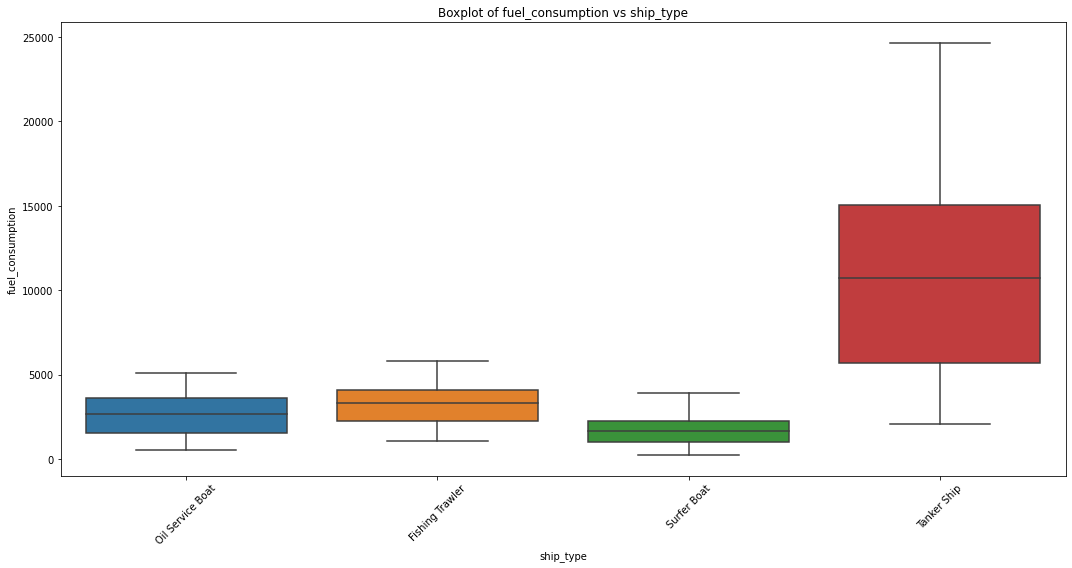

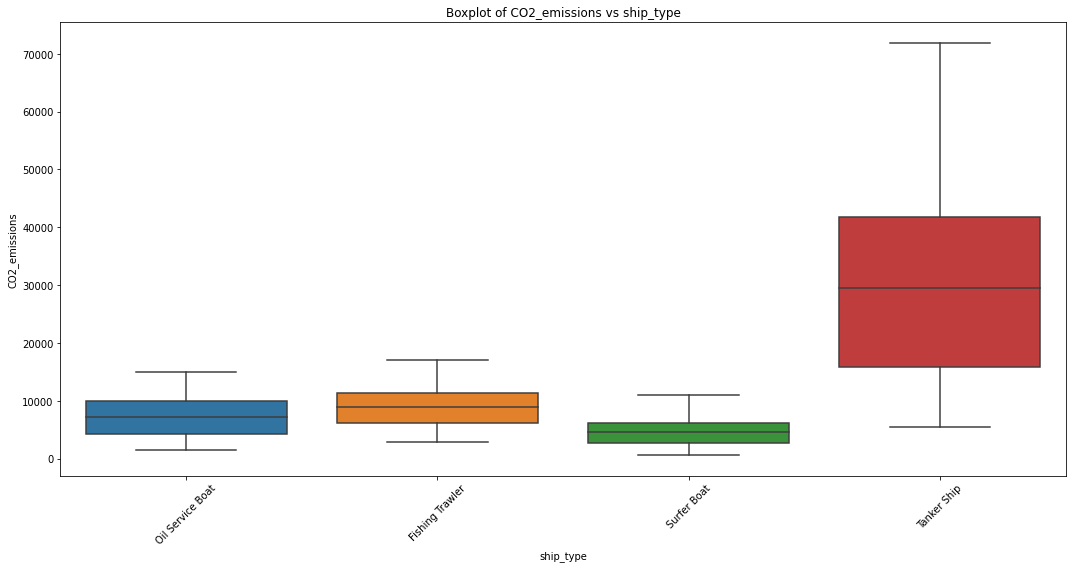

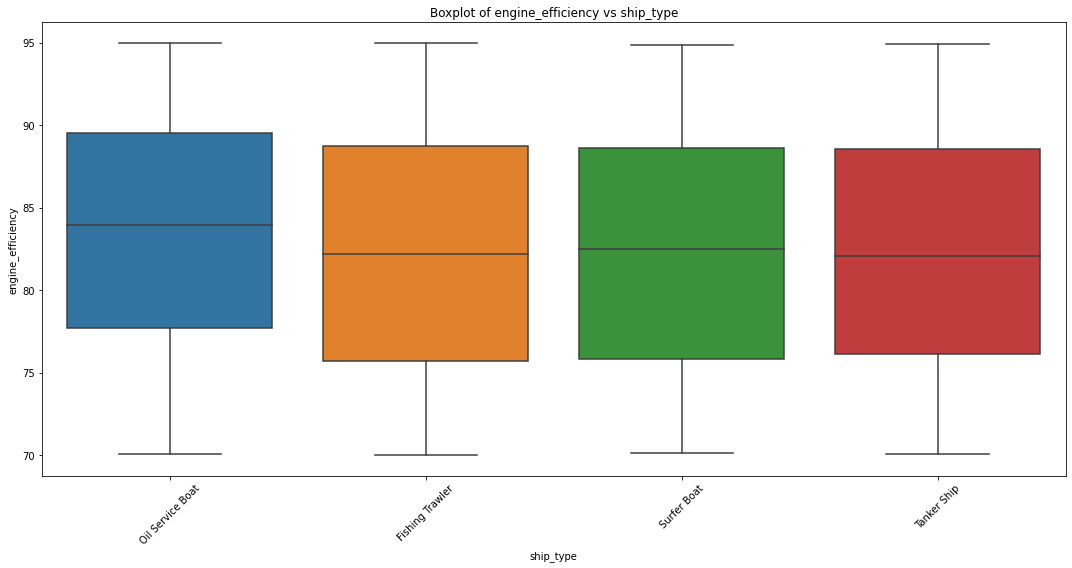

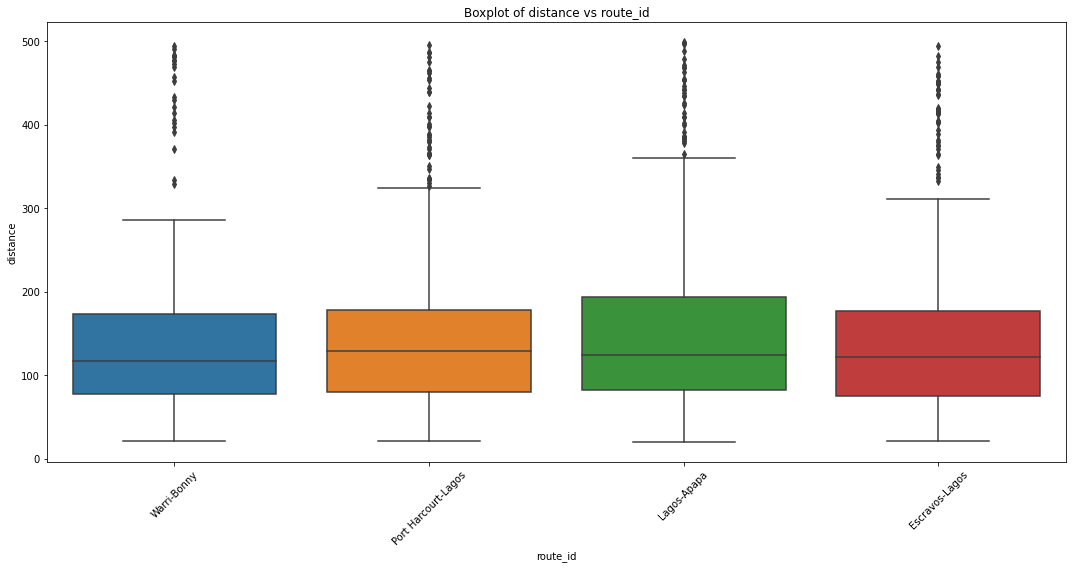

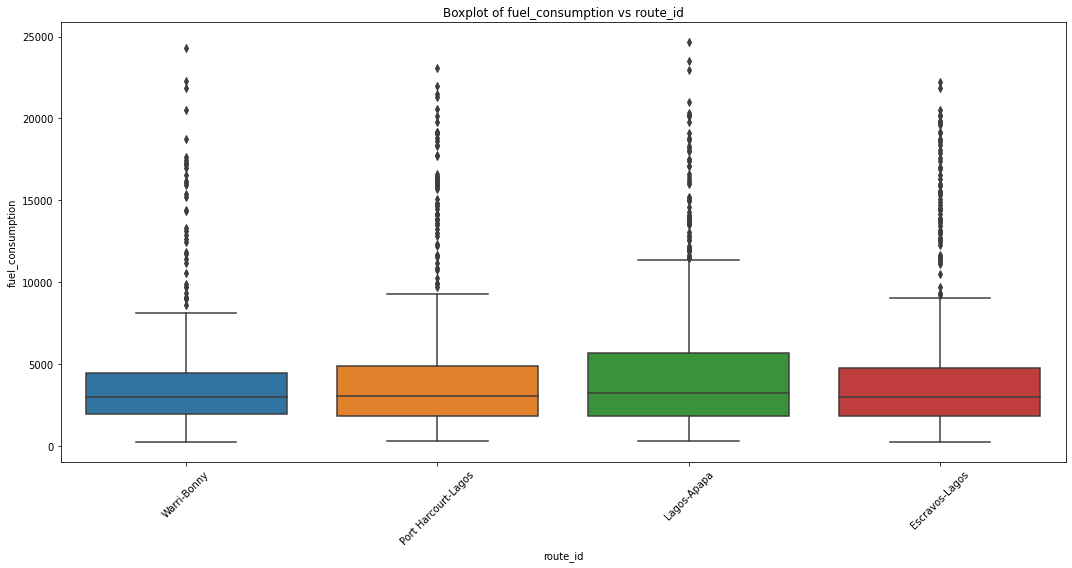

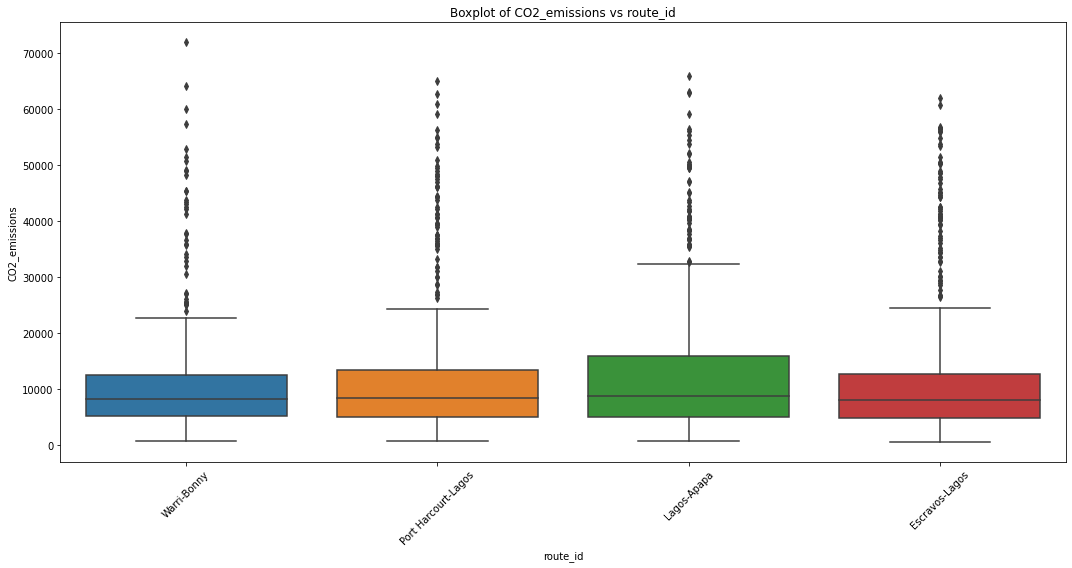

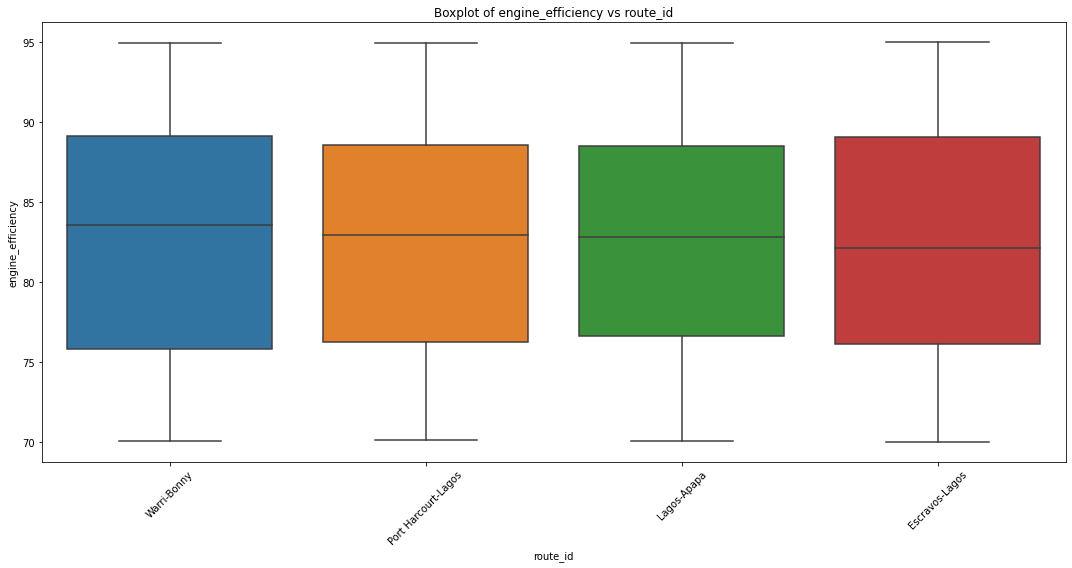

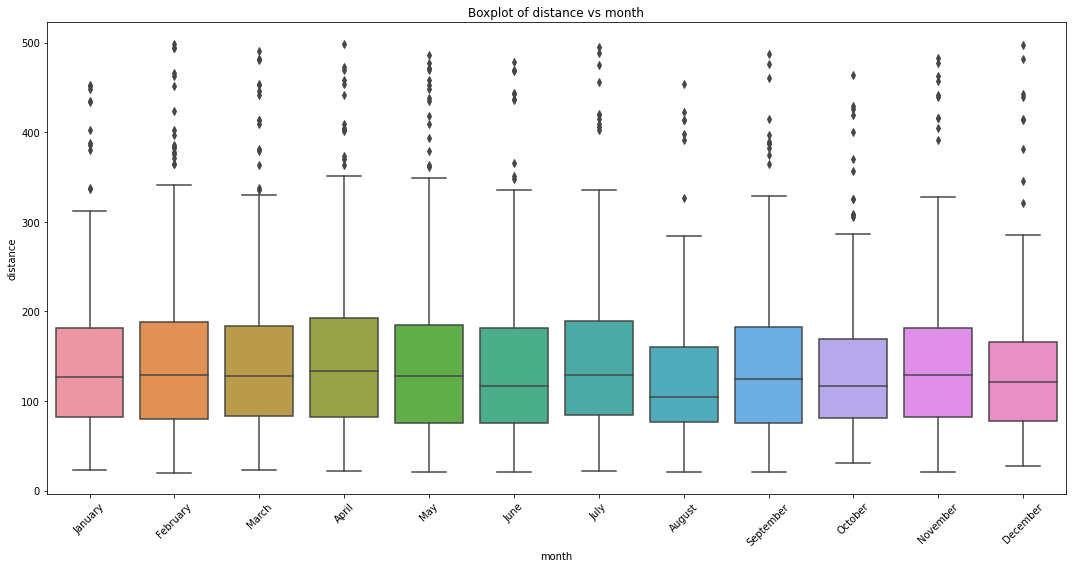

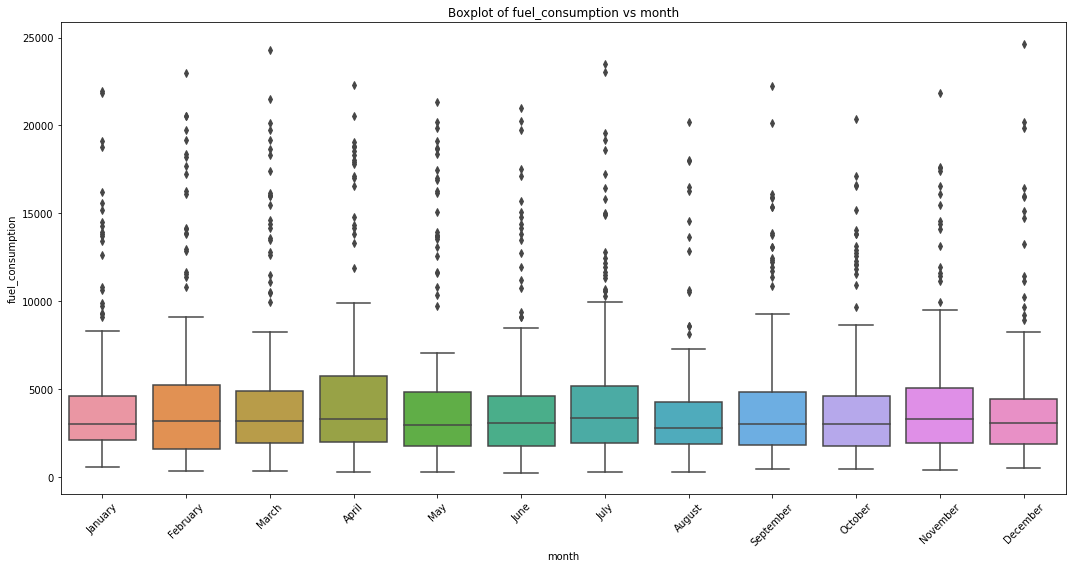

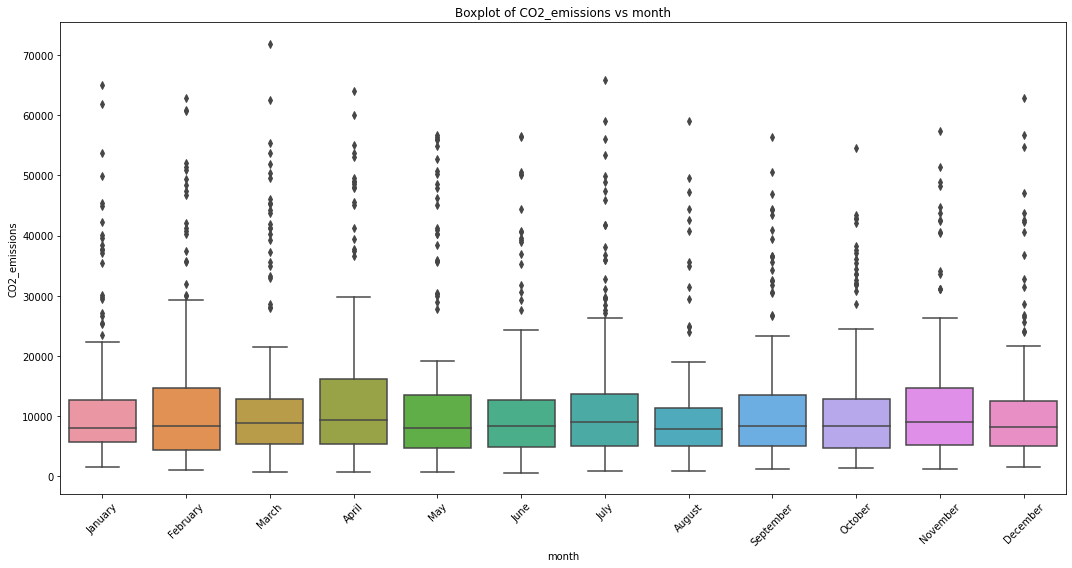

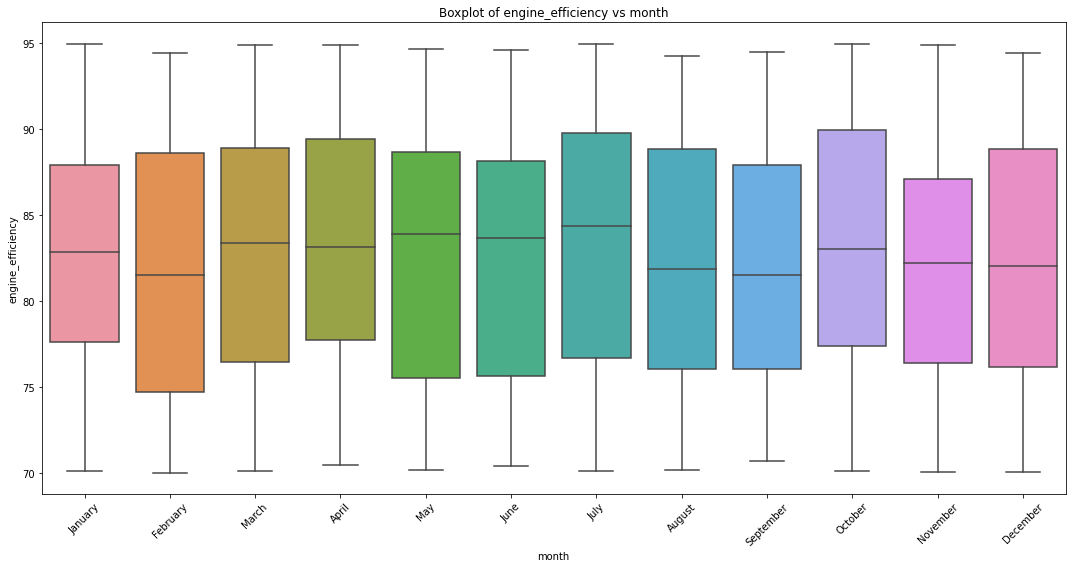

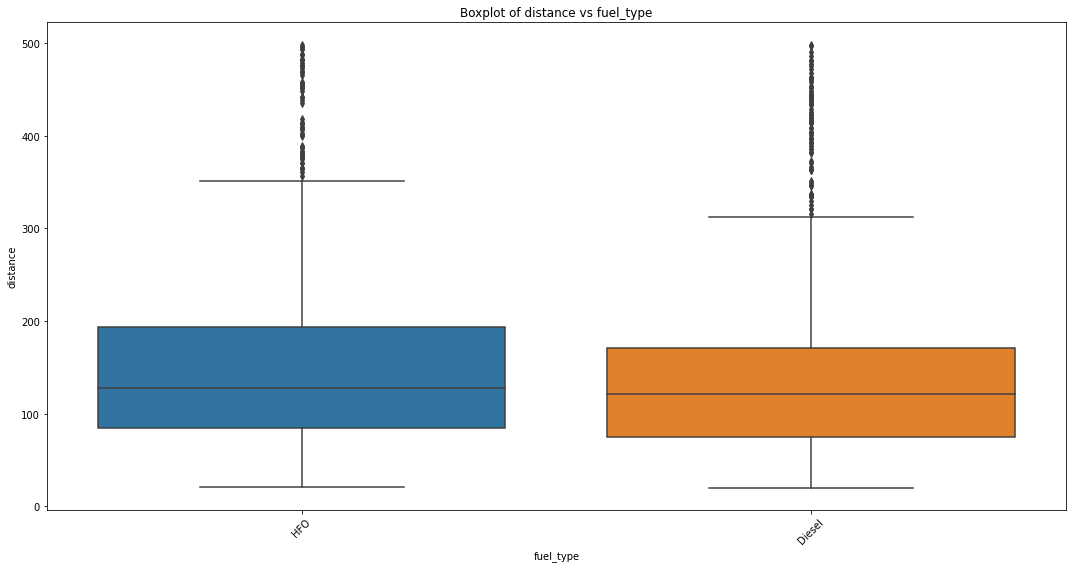

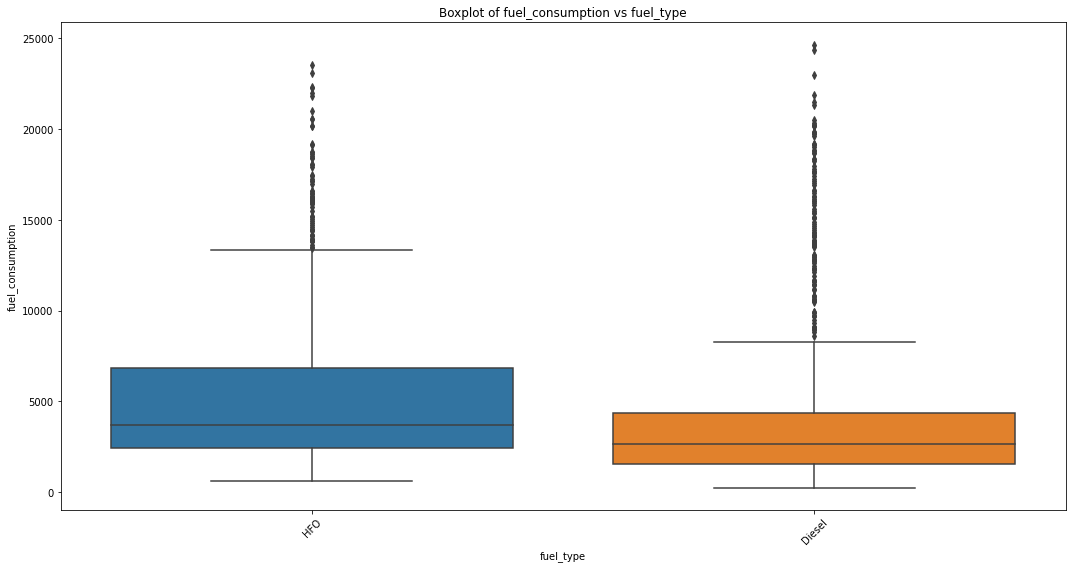

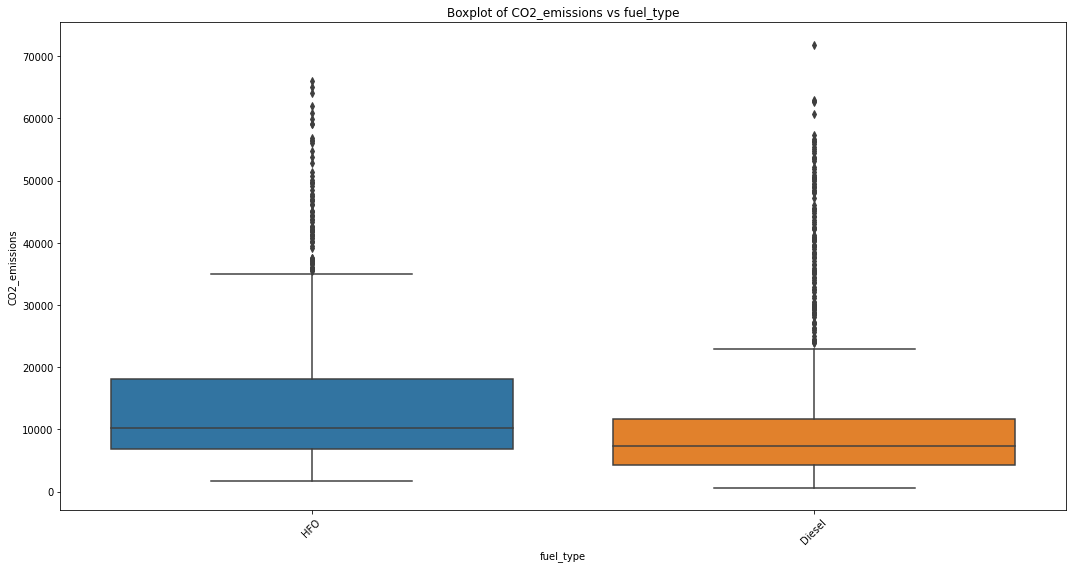

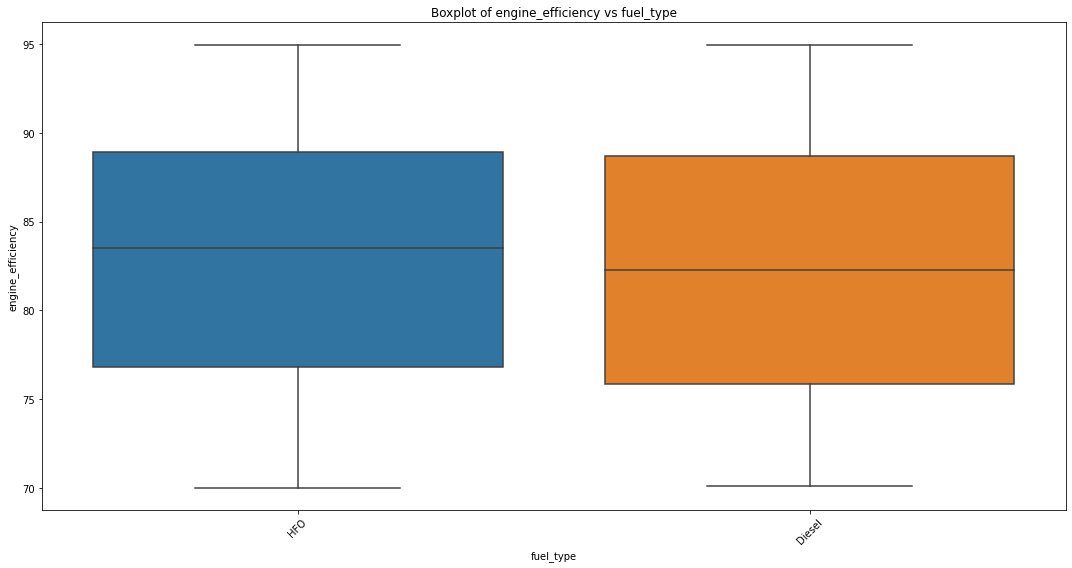

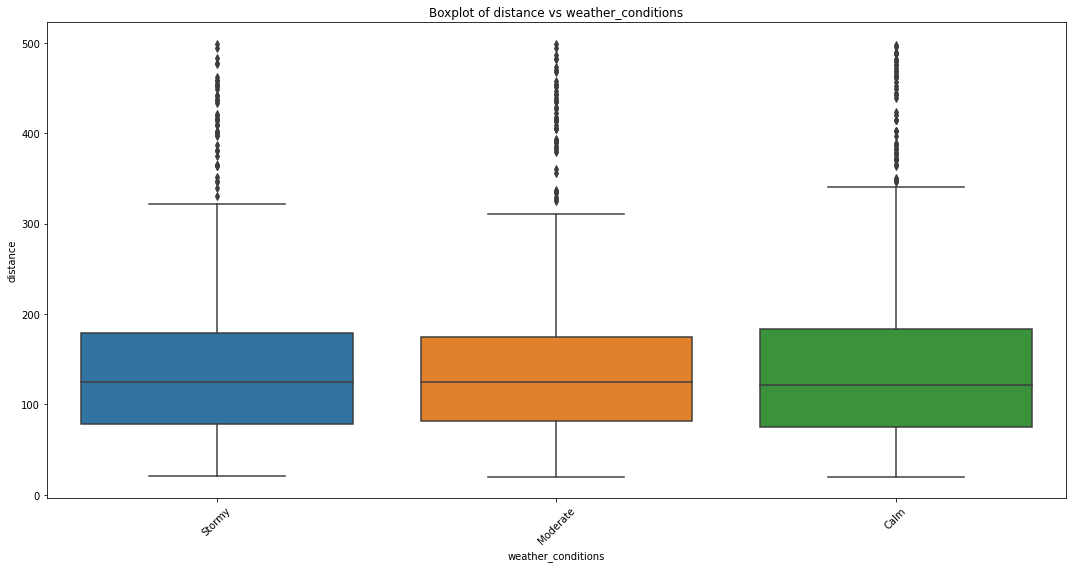

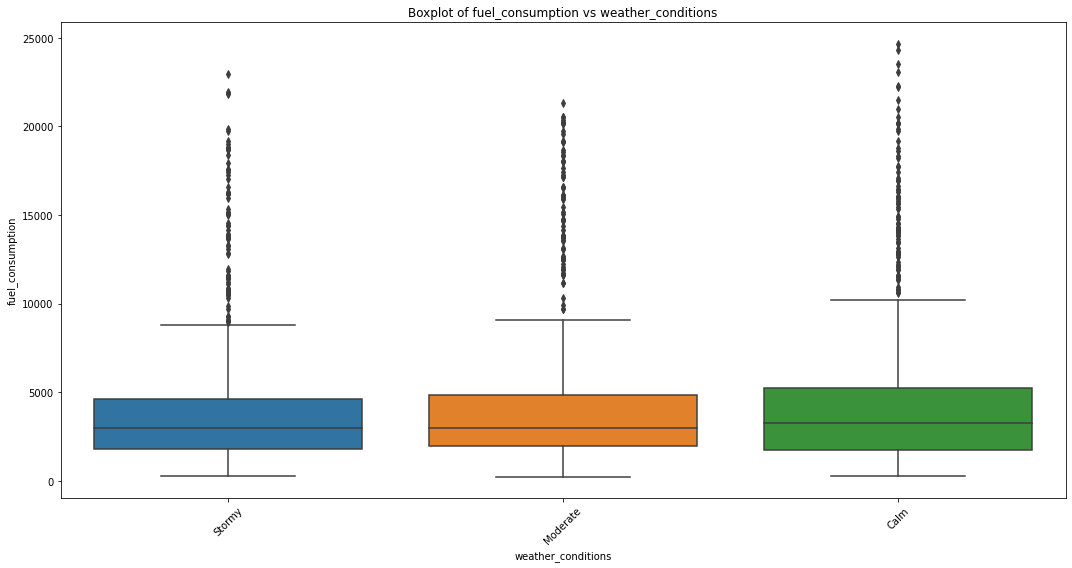

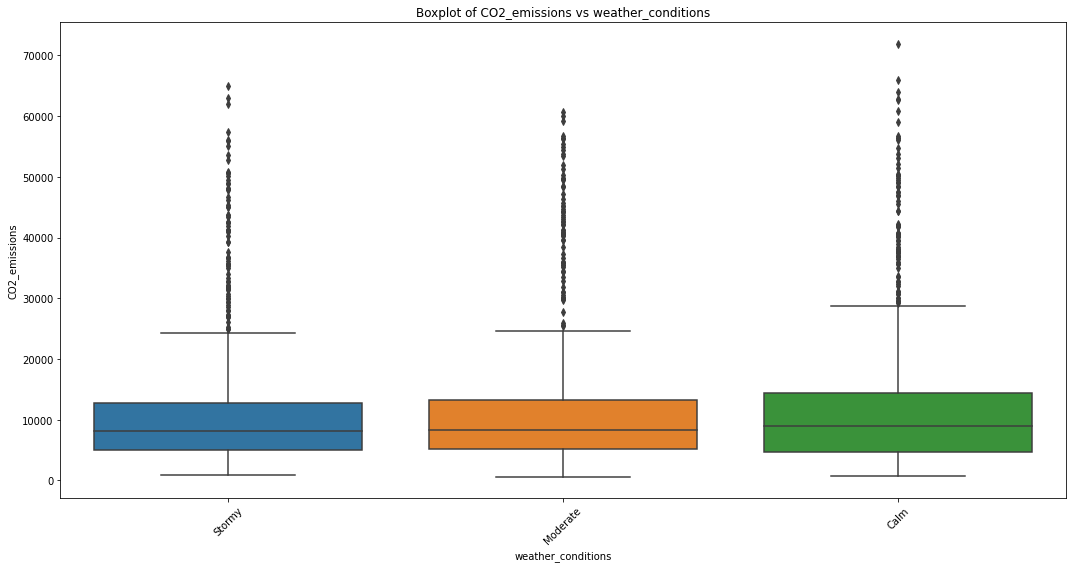

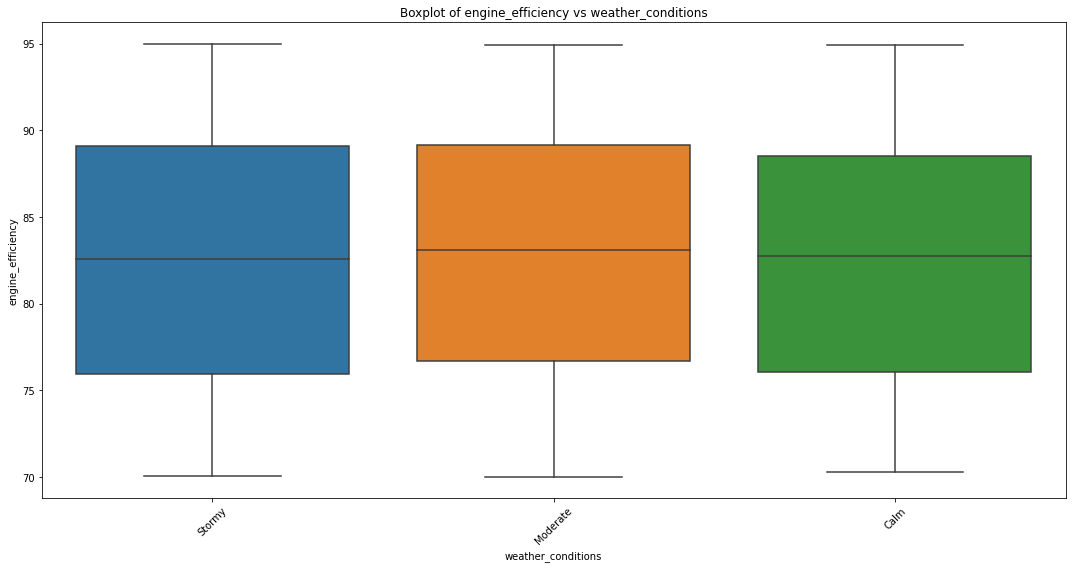

In [22]:
def plot_cat_vs_num(df: pd.DataFrame) -> None:
    """Plot categorical vs numerical columns"""
    cat_columns = df.select_dtypes(include=['object']).columns.drop('ship_id')
    num_columns = df.select_dtypes(include=['float64']).columns
    for cat in cat_columns:
        for num in num_columns:
            plt.figure(figsize=(15, 8))
            sns.boxplot(x=cat, y=num, data=df)
            plt.title(f'Boxplot of {num} vs {cat}')
            plt.xlabel(cat)
            plt.ylabel(num)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

plot_cat_vs_num(df)    

### EDA - Two Targets

In [23]:
target_columns = ['fuel_consumption', 'CO2_emissions']

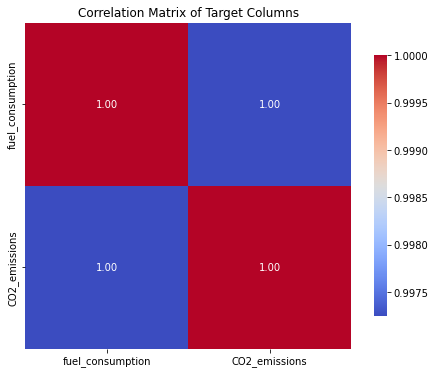

In [24]:
target_corr = df[target_columns].corr()

def plot_target_correlation(corr: pd.DataFrame) -> None:
    """Plot corelation matrix of target columns"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={'shrink': .8})
    plt.title('Correlation Matrix of Target Columns')
    plt.show()

plot_target_correlation(target_corr)

they have a strong positive correlation, which mean that as fuel_consumption increases, CO2_emissions also increase.

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


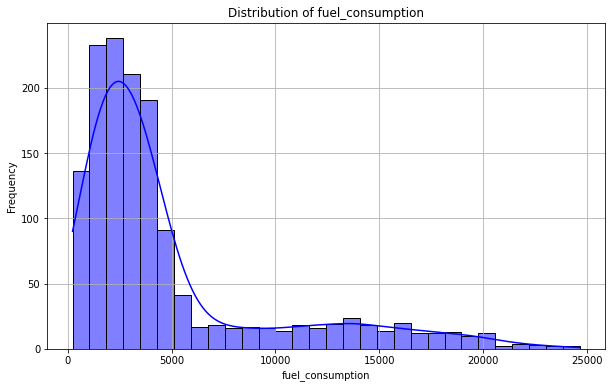

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


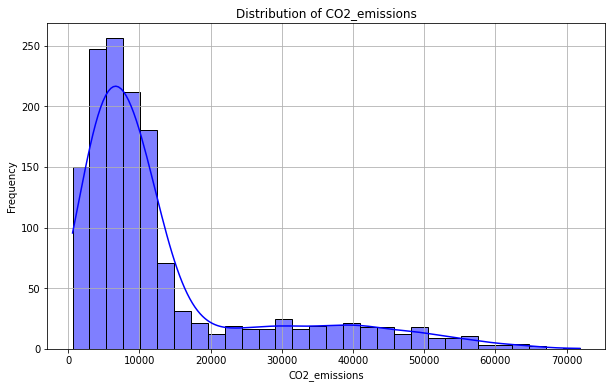

In [25]:
def plot_target_distribution(df: pd.DataFrame) -> None:
    """
    Plot distribution of target coloumns
    """

    for target_col in target_columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(df[target_col], kde=True, bins=30, color='blue')
        plt.title(f'Distribution of {target_col}')
        plt.xlabel(target_col)
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()
    
plot_target_distribution(df)
    

it has long tail distribution, so will apply log transformation

### Feature Engineering - Log Transformation

In [26]:
def apply_log_transform(df: pd.DataFrame) -> pd.DataFrame:
    """Apply log transformation to target columns"""

    for target in target_columns:
        df[target] = np.log1p(df[target])

    return df

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


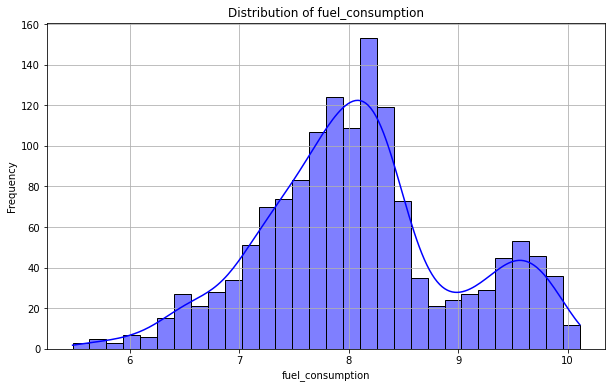

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


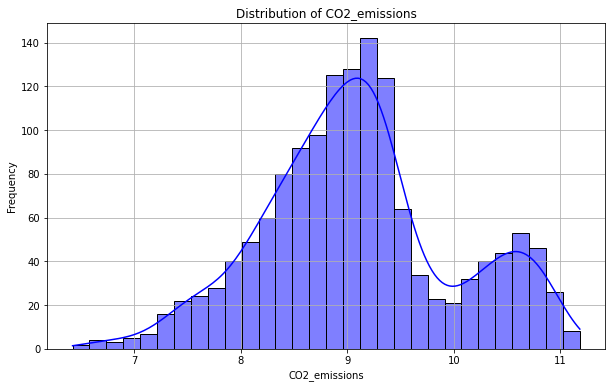

In [27]:
# see if log transform is applied
df = apply_log_transform(df)
plot_target_distribution(df)

## Modelling - Experiment Tracking

will going to do experiment tracking using mlflow

In [29]:
# Set the tracking URI 
mlflow.set_tracking_uri("sqlite:///mlflow.db")

# Set experiment name 
mlflow.set_experiment("ship_fuel_co2_mlops")

2025/07/07 19:52:34 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/07/07 19:52:34 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='file:///d:/github/ship_fuel_co2/notebooks/mlruns/1', creation_time=1751892754922, experiment_id='1', last_update_time=1751892754922, lifecycle_stage='active', name='ship_fuel_co2_mlops', tags={}>

In [30]:
def split_data(df: pd.DataFrame) -> tuple:
    """Split data into train and test sets """

    X = df.drop(columns=['ship_id', 'fuel_consumption', 'CO2_emissions'])
    y = df[['fuel_consumption', 'CO2_emissions']]

    df_train, df_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return df_train, df_test, y_train, y_test

df_train, df_test, y_train, y_test = split_data(df)

In [31]:
len(df_train), len(df_test), len(y_train), len(y_test)

(1152, 288, 1152, 288)

So we have 1152 data for training and 288 for testing

In [33]:
def preprocess_data(df_train: pd.DataFrame, df_test: pd.DataFrame) -> tuple:
    """Convert training and test DataFrames into vectorized arrays using DictVectorizer."""

    dv = DictVectorizer(sparse=False)
    train_dict = df_train.to_dict(orient='records')
    test_dict = df_test.to_dict(orient='records')

    # fit and transform
    X_train = dv.fit_transform(train_dict)
    X_test = dv.transform(test_dict)

    return X_train, X_test, dv

X_train, X_test, dv = preprocess_data(df_train, df_test)

In [34]:
from dataclasses import dataclass
@dataclass
class Dataset:
    """Dataset class to hold training and test data."""
    X_train: np.ndarray
    X_test: np.ndarray
    y_train: np.ndarray
    y_test: np.ndarray


In [35]:
def train_model(model_class, model_params: dict, dataset: Dataset) -> tuple:
    """ Train a model and log the experiment with mlflow"""

    with mlflow.start_run(run_name=f"{model_class.__name__}") as run:
        model = model_class(**model_params)
        mo_model = MultiOutputRegressor(model)
        mo_model.fit(dataset.X_train, dataset.y_train)

        y_pred = mo_model.predict(dataset.X_test)
        rmse = np.sqrt(np.mean((dataset.y_test - y_pred) ** 2))

        #log DictVectorizer
        with open("dv.pkl", "wb") as f:
            pickle.dump(dv, f)
        mlflow.log_artifact("dv.pkl", artifact_path='preprocessor')

        # log parameters and metrics
        mlflow.set_tag("model", model_class.__name__)
        mlflow.set_tag("model_params", str(model_params))
        mlflow.set_tag("type", "multioutput_regression")
        mlflow.log_params(model_params)
        mlflow.log_metric(f'{model_class.__name__}_rmse', rmse)
        mlflow.sklearn.log_model(mo_model, "model", registered_model_name=f'{model_class.__name__}_model')

        return mo_model, run.info.run_id, rmse


In [36]:
# Parameters for different models
param_grid = {
    LinearRegression: [{}],
    Ridge: [{'alpha': 0.1}, {'alpha': 1.0}, {'alpha': 10.0}],
    RandomForestRegressor: [
        {'n_estimators': 20, 'max_depth': 5},
        {'n_estimators': 50, 'max_depth': 5},
        {'n_estimators': 100, 'max_depth': 10}
    ],
    DecisionTreeRegressor:[
        {'max_depth': 5, 'min_samples_leaf': 10},
        {'max_depth': 10, 'min_samples_leaf': 20},
        {'max_depth': 15, 'min_samples_leaf': 30}
    ],
    XGBRegressor: [
        {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1},
        {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01},
        {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.01},
        {'n_estimators': 150, 'max_depth': 15, 'learning_rate': 0.005}
    ],
    LGBMRegressor: [
        {'n_estimators': 10, 'max_depth': 5, 'learning_rate': 0.1},
        {'n_estimators': 50, 'max_depth': 10, 'learning_rate': 0.01},
        {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.005}
    ]
}

In [38]:
def train_all_models(param_grid: dict, dataset: Dataset) -> pd.DataFrame:
    """Train all models in the param_grid and return a DataFrame with results"""

    results = []
    for model_class, param_list in param_grid.items():
        for params in param_list:
            start = time.time()
            model, run_id, rmse = train_model(model_class, params, dataset)
            duration = time.time() - start
            results.append({
                'model' : model_class.__name__,
                'params': params,
                'run_id': run_id,
                'rmse': rmse,
                'duration': duration
            })
            print((f'Training {model_class.__name__} with params: {params}'))
            print(f'Run ID: {run_id}, RMSE: {rmse:.4f}, Duration: {duration: .2f}')

    return pd.DataFrame(results)

dataset=Dataset(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
results_df = train_all_models(param_grid, dataset)
results_df.sort_values(by='rmse', ascending=True, inplace=True)
results_df.reset_index(drop=True, inplace=True)


# save to csv 
results_df.to_csv('../results/results_df.csv', index=False)

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'LinearRegression_model'.
Created version '1' of model 'LinearRegression_model'.
2025/07/07 19:59:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Training LinearRegression with params: {}
Run ID: 1eeeb4caab41425c877d5e35a7ff4688, RMSE: 0.3150, Duration:  13.93


Successfully registered model 'Ridge_model'.
Created version '1' of model 'Ridge_model'.
2025/07/07 19:59:38 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Training Ridge with params: {'alpha': 0.1}
Run ID: 00db9c6dd3044d6ea1239a950f8801cc, RMSE: 0.3150, Duration:  3.77


Registered model 'Ridge_model' already exists. Creating a new version of this model...
Created version '2' of model 'Ridge_model'.
2025/07/07 19:59:42 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Training Ridge with params: {'alpha': 1.0}
Run ID: 405fc629a44e46d58339bf931dc1fd78, RMSE: 0.3150, Duration:  3.76


Registered model 'Ridge_model' already exists. Creating a new version of this model...
Created version '3' of model 'Ridge_model'.
2025/07/07 19:59:46 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Training Ridge with params: {'alpha': 10.0}
Run ID: 5e39ffd2230e420aa63191950afdf328, RMSE: 0.3157, Duration:  3.84


Successfully registered model 'RandomForestRegressor_model'.
Created version '1' of model 'RandomForestRegressor_model'.
2025/07/07 19:59:50 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Training RandomForestRegressor with params: {'n_estimators': 20, 'max_depth': 5}
Run ID: 46faee772b9844c78d6a88773c4e9517, RMSE: 0.1743, Duration:  4.20


Registered model 'RandomForestRegressor_model' already exists. Creating a new version of this model...
Created version '2' of model 'RandomForestRegressor_model'.
2025/07/07 19:59:56 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Training RandomForestRegressor with params: {'n_estimators': 50, 'max_depth': 5}
Run ID: 6982ece16346440b858ff218186fb4e9, RMSE: 0.1728, Duration:  5.80


Registered model 'RandomForestRegressor_model' already exists. Creating a new version of this model...
Created version '3' of model 'RandomForestRegressor_model'.
2025/07/07 20:00:01 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Training RandomForestRegressor with params: {'n_estimators': 100, 'max_depth': 10}
Run ID: 522aa59d73424fac81808676c74e5f64, RMSE: 0.1520, Duration:  5.14


Successfully registered model 'DecisionTreeRegressor_model'.
Created version '1' of model 'DecisionTreeRegressor_model'.
2025/07/07 20:00:05 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Training DecisionTreeRegressor with params: {'max_depth': 5, 'min_samples_leaf': 10}
Run ID: 6dd0e14612194d4dbb7c793f09f9116b, RMSE: 0.1966, Duration:  3.85


Registered model 'DecisionTreeRegressor_model' already exists. Creating a new version of this model...
Created version '2' of model 'DecisionTreeRegressor_model'.
2025/07/07 20:00:09 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Training DecisionTreeRegressor with params: {'max_depth': 10, 'min_samples_leaf': 20}
Run ID: 73f034ab7a3c4810b5159f043b12ddb9, RMSE: 0.1747, Duration:  3.80


Registered model 'DecisionTreeRegressor_model' already exists. Creating a new version of this model...
Created version '3' of model 'DecisionTreeRegressor_model'.
2025/07/07 20:00:12 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Training DecisionTreeRegressor with params: {'max_depth': 15, 'min_samples_leaf': 30}
Run ID: ece66d76445244e9953275c36376865a, RMSE: 0.1906, Duration:  3.75


Successfully registered model 'XGBRegressor_model'.
Created version '1' of model 'XGBRegressor_model'.
2025/07/07 20:00:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Training XGBRegressor with params: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}
Run ID: 23d42f65f3c54b1ca2423d0204ca989e, RMSE: 0.1498, Duration:  5.57


Registered model 'XGBRegressor_model' already exists. Creating a new version of this model...
Created version '2' of model 'XGBRegressor_model'.
2025/07/07 20:00:22 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Training XGBRegressor with params: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01}
Run ID: f7219cdb554b487dbf8e4ec046143f1a, RMSE: 0.5971, Duration:  4.59


Registered model 'XGBRegressor_model' already exists. Creating a new version of this model...
Created version '3' of model 'XGBRegressor_model'.
2025/07/07 20:00:27 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Training XGBRegressor with params: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.01}
Run ID: 3d289fd277f045548a7cc2cceeec03be, RMSE: 0.3880, Duration:  5.02


Registered model 'XGBRegressor_model' already exists. Creating a new version of this model...
Created version '4' of model 'XGBRegressor_model'.
2025/07/07 20:00:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Training XGBRegressor with params: {'n_estimators': 150, 'max_depth': 15, 'learning_rate': 0.005}
Run ID: a07e7f294d0b4842b4cb822cf540fa15, RMSE: 0.4789, Duration:  6.62
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 27
[LightGBM] [Info] Start training from score 8.078596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

Successfully registered model 'LGBMRegressor_model'.
Created version '1' of model 'LGBMRegressor_model'.
2025/07/07 20:00:39 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Training LGBMRegressor with params: {'n_estimators': 10, 'max_depth': 5, 'learning_rate': 0.1}
Run ID: fb27ccdff2854b8abce9cc02250f01be, RMSE: 0.3667, Duration:  5.14
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 27
[LightGBM] [Info] Start training from score 8.078596
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 27
[LightGBM] [Info] Start training from score 9.089146


Registered model 'LGBMRegressor_model' already exists. Creating a new version of this model...
Created version '2' of model 'LGBMRegressor_model'.
2025/07/07 20:00:44 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Training LGBMRegressor with params: {'n_estimators': 50, 'max_depth': 10, 'learning_rate': 0.01}
Run ID: d53841076fd44e7dbbb5b244e915c094, RMSE: 0.5879, Duration:  4.35
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 27
[LightGBM] [Info] Start training from score 8.078596
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 27
[LightGBM] [Info] Start training from score 9.089146


Registered model 'LGBMRegressor_model' already exists. Creating a new version of this model...
Created version '3' of model 'LGBMRegressor_model'.
2025/07/07 20:00:48 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Training LGBMRegressor with params: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.005}
Run ID: 5c9886f504244970bd0cc702fec636d4, RMSE: 0.5886, Duration:  4.19


Actually we can accsess the results in mlflow ui too but i feel i just want to do extra, so that's why i made that results_df.

In [39]:
# see the results
results_df

,model,params,run_id,rmse,duration
0,XGBRegressor,"{'n_estimators': 50, 'max_depth': 5, 'learning...",23d42f65f3c54b1ca2423d0204ca989e,0.149752,5.565986
1,RandomForestRegressor,"{'n_estimators': 100, 'max_depth': 10}",522aa59d73424fac81808676c74e5f64,0.151989,5.136516
2,RandomForestRegressor,"{'n_estimators': 50, 'max_depth': 5}",6982ece16346440b858ff218186fb4e9,0.172765,5.799282
3,RandomForestRegressor,"{'n_estimators': 20, 'max_depth': 5}",46faee772b9844c78d6a88773c4e9517,0.174307,4.198240
4,DecisionTreeRegressor,"{'max_depth': 10, 'min_samples_leaf': 20}",73f034ab7a3c4810b5159f043b12ddb9,0.174722,3.797565
5,DecisionTreeRegressor,"{'max_depth': 15, 'min_samples_leaf': 30}",ece66d76445244e9953275c36376865a,0.190577,3.751283
6,DecisionTreeRegressor,"{'max_depth': 5, 'min_samples_leaf': 10}",6dd0e14612194d4dbb7c793f09f9116b,0.196555,3.850005
7,LinearRegression,{},1eeeb4caab41425c877d5e35a7ff4688,0.314971,13.927675
8,Ridge,{'alpha': 0.1},00db9c6dd3044d6ea1239a950f8801cc,0.314976,3.770409
9,Ridge,{'alpha': 1.0},405fc629a44e46d58339bf931dc1fd78,0.315022,3.762112


In [ ]:
print("y_train shape:", y_train.shape)
print("y_train min:", y_train.min(axis=0))
print("y_train max:", y_train.max(axis=0))
print("y_train mean:", y_train.mean(axis=0))
print("y_train std:", y_train.std(axis=0))

y_train shape: (1152, 2)
y_train min: fuel_consumption    5.475961
CO2_emissions       6.424350
dtype: float64
y_train max: fuel_consumption    10.112513
CO2_emissions       11.182645
dtype: float64
y_train mean: fuel_consumption    8.078596
CO2_emissions       9.089146
dtype: float64
y_train std: fuel_consumption    0.882567
CO2_emissions       0.886558
dtype: float64


So, since the model that has good rmse is xgboost with 0.149752, we will register it using mlflow

### Register the model and Testing

In [42]:
def register_best_model(run_id: str, model_name: str) -> str:
    """Register the model from a specific Mlflow run"""

    client = MlflowClient()
    client.create_registered_model(model_name)

    # register the best model
    model_uri = f"runs:/{run_id}/model"
    model_version = client.create_model_version(
        name=model_name, 
        source=model_uri, 
        run_id=run_id
        )
    print(f'Model registered: {model_name} (version {model_version.version})')
    return f'models:/{model_name}/{model_version.version}'

best_run_id = results_df.loc[0, 'run_id']
model_name = 'ship_fuel_co2_predictor'
model_uri = register_best_model(best_run_id, model_name)

Model registered: ship_fuel_co2_predictor (version 1)


In [43]:
model_uri

'models:/ship_fuel_co2_predictor/1'

In [45]:
def load_model_and_dv(model_uri: str, artifact_path: str) -> tuple:
    """Load the registered model and dictvectorizer artifact"""

    # load model from registry
    model = mlflow.sklearn.load_model(model_uri)

    # download dv.pkl from mlflow artifacts
    client = MlflowClient()
    model_name, model_version = model_uri.replace('models:/', "").split('/')
    model_info = client.get_model_version(name=model_name, version=model_version)
    run_id = model_info.run_id

    local_path = client.download_artifacts(run_id=run_id, path=artifact_path)

    with open(local_path, 'rb') as f:
        dv = pickle.load(f)

    return model, dv

artifact_path = 'preprocessor/dv.pkl'
model, dv = load_model_and_dv(model_uri, artifact_path)

time to make prediction on sample data

In [46]:
def make_prediction(model, dv, sample: dict) -> pd.DataFrame:
    """Make prediction using best model that we have"""

    X_sample = dv.transform([sample])
    y_pred = model.predict(X_sample)
    y_pred_ori = np.expm1(y_pred) # because we were applying log transformation

    target_columns = ['fuel_consumption', 'CO2_emissions']
    df_pred = pd.DataFrame(y_pred_ori, columns=target_columns)
    
    return df_pred

In [47]:
# sample for testing the model
sample = {
    'ship_type' : 'Oil Service Boat',
    'route_id'  : 'Lagos-Apapa',
    'month'     : 'December',
    'distance'  : 134,
    'fuel_type' : 'HFO',
    'weather_condition' : "Calm",
    'engine_efficiency' : 90
}

df_results = make_prediction(model, dv, sample)
print(df_results)

   fuel_consumption  CO2_emissions
0       3870.245361   10822.174805


FINALLY, IT'S DONE!!